# Non-negative Matric Factorisation (NMF)

NMF is a decomposition technique commonly used for dimensional reduction (like, for exmaple, the commonly used PCA). However, NMF is different in that it assumes none of the data is negative. Therefore, it has become popular as method of investigating spatial components. Some great resources can be found [here](https://github.com/devinpleuler/analytics-handbook), [here](https://dtai.cs.kuleuven.be/sports/blog/player-vectors-characterizing-soccer-players-playing-style), [here](https://github.com/andrewRowlinson/expected-goals-thesis/blob/master/notebooks/non-negative-matrix-factorisation.ipynb) and [here](https://znstrider.github.io/2018-11-14-SBData-Non-Negative-Matrix-Factorization/), with a more indepth look behind NMF [here](https://squared2020.com/2018/10/04/understanding-trends-in-the-nba-how-nnmf-works/).

This notebook is an exploration into using NMF to identify different styles of play and look at how similar players are - something which could be useful for scouting purposes. In particular, I separately look at shooting, passing and progressive carries.

Begin by importing the necessary modules.

In [1]:
import sys,os
sys.path.append(os.path.abspath("modules"))
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import sklearn.decomposition as skd
from scipy.ndimage import gaussian_filter

import importing_sb as imsb
import draw_pitch as dp

plt.style.use('football')

%matplotlib inline

Offensively, for example, we can look at the areas in which *shots*, *passes* and *carries* are made. From this we can then look at where players perform these actions.

I will use the 18/19 WSL data from the StatsBomb [free data](https://statsbomb.com/academy/).

In [2]:
data_dir = 'data/open-data/data/'
comp_data = imsb.open_data(data_dir + 'competitions.json')

In [3]:
comp_id = 37
seasons = [i['season_id'] for i in comp_data if i['competition_id'] == comp_id]
match_data = [sorted(imsb.open_data(data_dir + 'matches/{}/{}.json'.format(comp_id,i)), key = lambda k:k['match_date']) for i in seasons]

In [4]:
match_ids = []
for year in range(len(match_data)):
    match_df = pd.DataFrame(match_data[year])
    match_ids.append(match_df['match_id'].values)

In [5]:
seasons = ['19/20','18/19']
event_data = {}
lineup_data = {}
for i in range(len(seasons)):
    event_data[seasons[i]] = []
    lineup_data[seasons[i]] = []
    for match in match_ids[i]:
        event_data[seasons[i]].append(imsb.open_data(data_dir + 'events/{}.json'.format(str(match))))
        lineup_data[seasons[i]].append(imsb.open_data(data_dir + 'lineups/{}.json'.format(str(match))))

Finding the position of every player using their most common position in the starting lineup.

In [6]:
position_list = []
for i in range(len(event_data['18/19'])):
    position_list.append(pd.concat([pd.json_normalize(event_data['18/19'][i][0]['tactics']['lineup'])[['player.name','position.name']],
               pd.json_normalize(event_data['18/19'][i][1]['tactics']['lineup'])[['player.name','position.name']]],
              ignore_index=True))

df_positions = pd.concat(position_list,ignore_index=True).groupby(['player.name','position.name']).size()

positions = []
for i in df_positions.index.get_level_values(0).unique():
    positions.append(df_positions.loc[i].sort_values(ascending=False).index[0])
    
df_pos = pd.DataFrame(data={'pos':positions},index=df_positions.index.get_level_values(0).unique())

Finding the team of every player.

In [7]:
df = pd.DataFrame()
for match in lineup_data['18/19']:
    cond1 = [x not in df.index for x in pd.json_normalize(match[0]['lineup'])['player_name'].values]
    cond2 = [x not in df.index for x in pd.json_normalize(match[1]['lineup'])['player_name'].values]
    
    df = df.append(pd.DataFrame(data={'team':match[0]['team_name']},index=pd.json_normalize(match[0]['lineup'])[cond1]['player_name'].values))
    df = df.append(pd.DataFrame(data={'team':match[1]['team_name']},index=pd.json_normalize(match[1]['lineup'])[cond2]['player_name'].values))

There appears to be some mismatch. There are more players when finding the teams, so there are some players without a position.

In [8]:
for x in df.index:
    if x not in df_pos.index:
        print(x)

Leah Burridge
Jessica Park
Shania Hayles
Katie Robinson
Liberty Piggott
Tabea Kemme
Ruby Grant
Amelia Hazard
Lauren Thomas
Simran Jhamat
Melisa Filis
Poppy Wilson
Missy Bo Kearns
Ashley Hodson
Danielle Carter
Annabel Blanchard
Olivia Chance
Charlie Taylor


In [9]:
df_players = pd.concat([df,df_pos],axis=1)

In [10]:
df_players.head()

,team,pos
Josanne Potter,Reading WFC,Left Center Back
Fara Williams,Reading WFC,Center Attacking Midfield
Charlotte Estcourt,Reading WFC,Right Center Midfield
Lily Woodham,Reading WFC,Left Back
Rachel Furness,Reading WFC,Center Defensive Midfield


Creating separate dataframes for various positions.

In [11]:
df_def = df_players[df_players['pos'].str.endswith('Back',na=False)]
df_cdef = df_players[df_players['pos'].str.endswith('Center Back',na=False)]
df_mid = df_players[df_players['pos'].str.endswith('Midfield',na=False)]
df_cmid = df_players[(df_players['pos'].str.endswith('Defensive Midfield',na=False))|
                        (df_players['pos'].str.endswith('Center Midfield',na=False))|
                        (df_players['pos'].str.endswith('Attacking Midfield',na=False))]
df_wing = df_players[(df_players['pos'].str.endswith('Wing Back',na=False))|
                        (df_players['pos'].str.endswith('Right Midfield',na=False))|
                        (df_players['pos'].str.endswith('Left Midfield',na=False))|
                        (df_players['pos'].str.endswith('Wing',na=False))]
df_for = df_players[(df_players['pos'].str.endswith('Wing',na=False))|
                        (df_players['pos'].str.endswith('Forward',na=False))|
                        (df_players['pos'].str.endswith('Striker',na=False))]
df_str = df_players[(df_players['pos'].str.endswith('Forward',na=False))|
                        (df_players['pos'].str.endswith('Striker',na=False))]

## Shooting

The StatsBomb data has y=0 as the top of the pitch, which is inverted for typical pitch plotting of events. However, when I plot heatmaps/pitch histograms here the y-axis becomes flipped again. Hence, when importing the StatsBomb data I will not change the y-coordinates.

In [12]:
df_shots = {}
for i in seasons:
    df_shots[str(i)] = [imsb.get_shots(match) for match in event_data[str(i)]]
    df_shots[str(i)] = pd.concat(df_shots[str(i)],ignore_index=True)
    df_shots[str(i)] = df_shots[str(i)][(df_shots[str(i)]['shot_type'] == "Open Play")
                                      &(df_shots[str(i)]["x"] > 60)].copy()

In [13]:
df_shots['18/19'].groupby('player').count().sort_values('index',ascending=False).head(10)['index']

player
Vivianne Miedema    111
Georgia Stanway      71
Nikita Parris        70
Fara Williams        57
Erin Cuthbert        52
Francesca Kirby      52
Bethany England      51
Brooke Chaplen       50
Charlie Wellings     46
Katie McCabe         39
Name: index, dtype: int64

Histogram of all open play shots in the WSL 18/19 season.

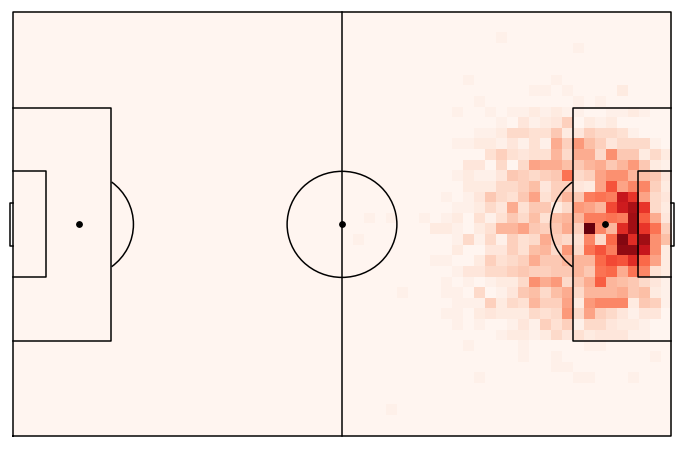

In [14]:
hist, ygrid, xgrid = np.histogram2d(df_shots['18/19']['y'],df_shots['18/19']['x'],
                                    bins=(40,60),range=[[0,80],[0,120]])
fig,ax = dp.draw_pitch('w','k','h','f')
ax.imshow(hist, extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)

Applying Gaussian smoothing. The $\sigma=3$ value is chosen by hand.

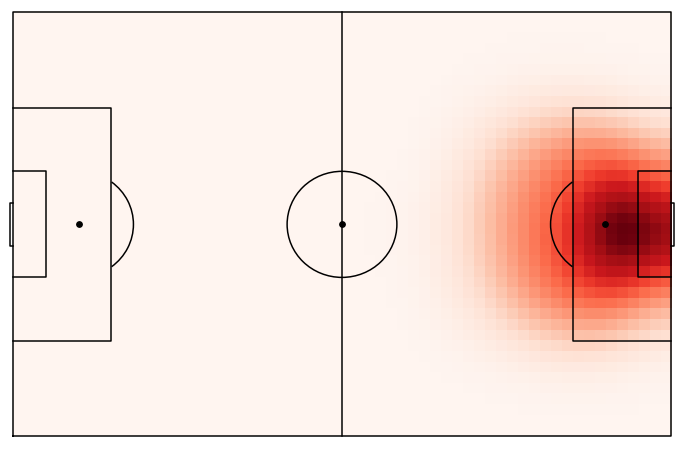

In [15]:
fig,ax = dp.draw_pitch('w','k','h','f')
ax.imshow(gaussian_filter(hist, 3), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)

Ordering players by most shots taken.

In [16]:
players_sht = df_shots['18/19']['player'].value_counts().index

Now make a smoothed histogram of each player's shots.

In [17]:
X = np.zeros((len(players_sht), 40*60))
for i in range(len(players_sht)):
    df_player = df_shots['18/19'][df_shots['18/19']['player'] == players_sht[i]]
    hist, *_ = np.histogram2d(df_player['y'].values,df_player['x'].values,bins=(40,60),range=[[0,80],[0,120]])
    X[i] = gaussian_filter(hist,3).flatten()

As an example, here is the heatmap for the player who has taken the second most shots - Georgia Stanway of Man City.

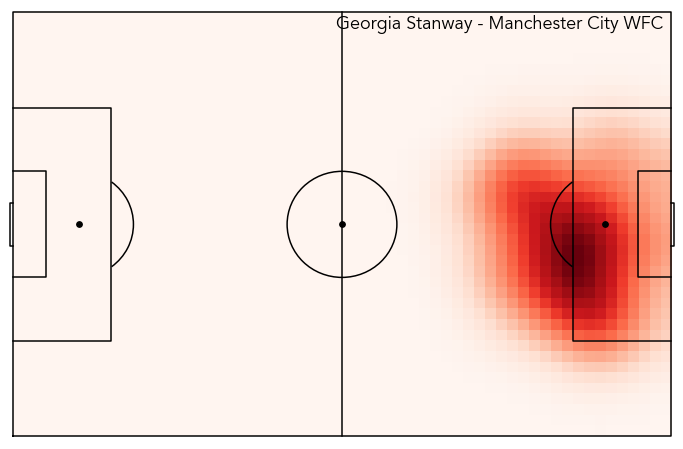

In [18]:
fig,ax = dp.draw_pitch('w','k','h','f')
p = 1
ax.imshow(X[p].reshape(40,60), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
ax.text(0.98,0.95,str(players_sht[p])+" - "+str(df_players.loc[players_sht[p]]['team']),
        transform=ax.transAxes,fontsize=18,ha='right')
plt.show()

Perform NMF using a specified number of components, which is chosen by hand upon considering the result.

In [19]:
n_com = 4
model = skd.NMF(n_components=n_com, init='random', random_state=42)
W = model.fit_transform(X)
H = model.components_

In [20]:
print(H.shape)
print(W.shape)

(4, 2400)
(190, 4)


`H` are the components we have reduced to. `W` shows each player in terms of each component.

Here is what each of the four components looks like.

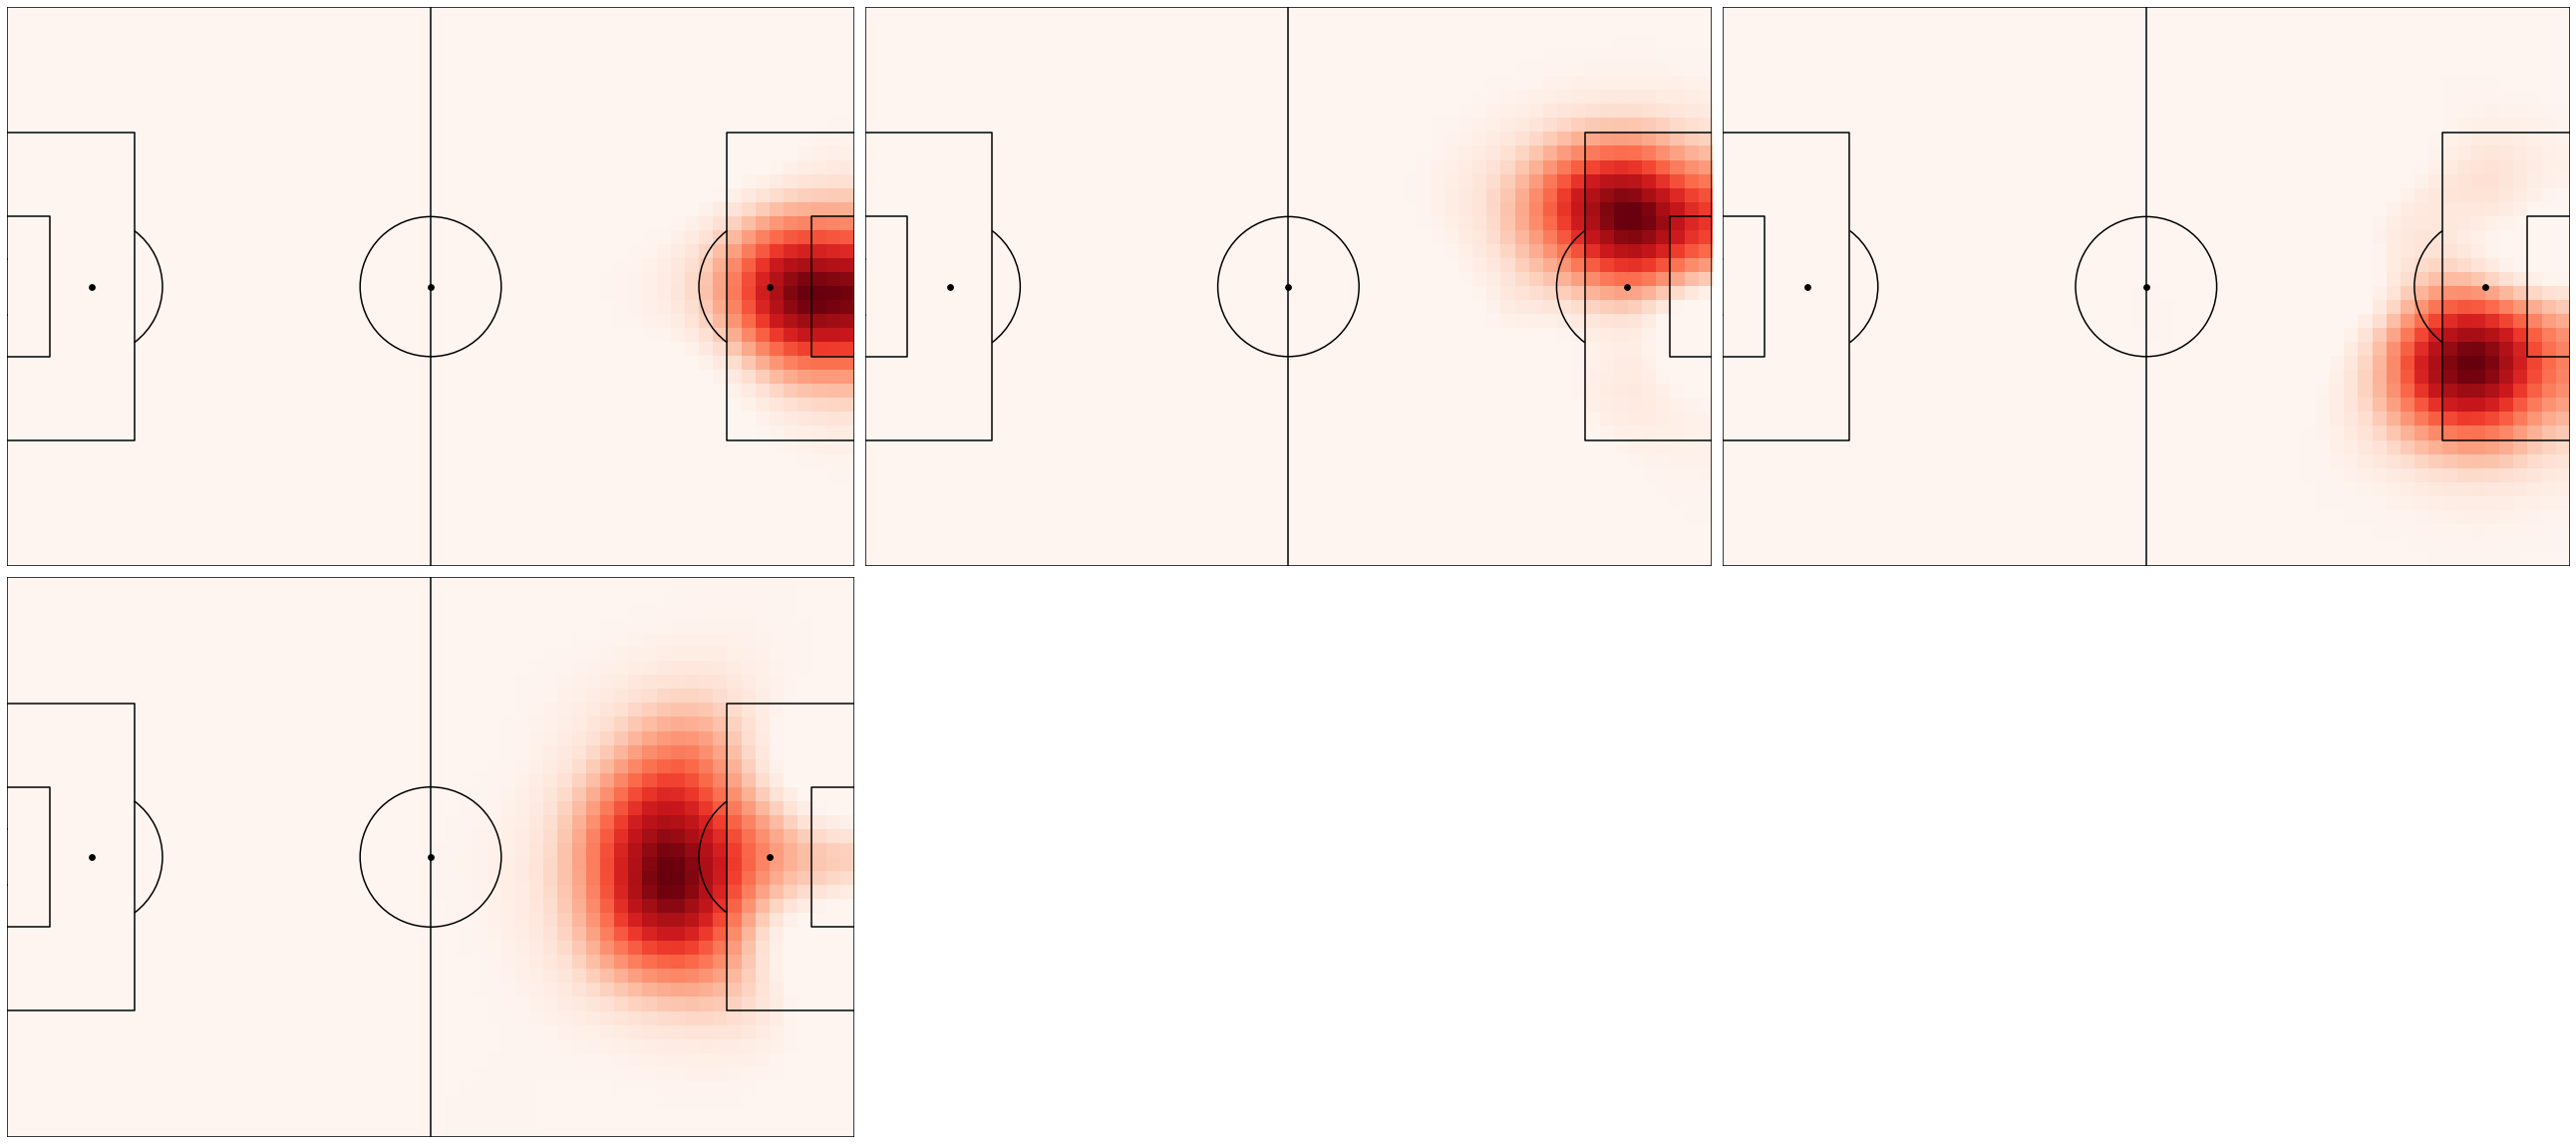

In [21]:
n_rows = 3
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(36,8*n_rows))
count = 0
for i in range(n_rows):
    for j in range(n_cols):
        if count > n_com-1:
            axs[i, j].remove()
        else:
            _, ax = dp.draw_pitch('w','k','h','f',figax=(fig,axs[i,j]))
            ax.imshow(H[count].reshape(40,60), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
        count += 1
        
plt.tight_layout()

We see close central shots, left shots, right shots and far shots corresponding to the components 0,1,2,3.

We can now look at how each players is associated to each zone - where they take their shots. I plot the distributions of the top 9 playres by shot count.

In [22]:
df_weights = pd.DataFrame(W, index=players_sht, columns=['Zone {}'.format(i) for i in range(n_com)])

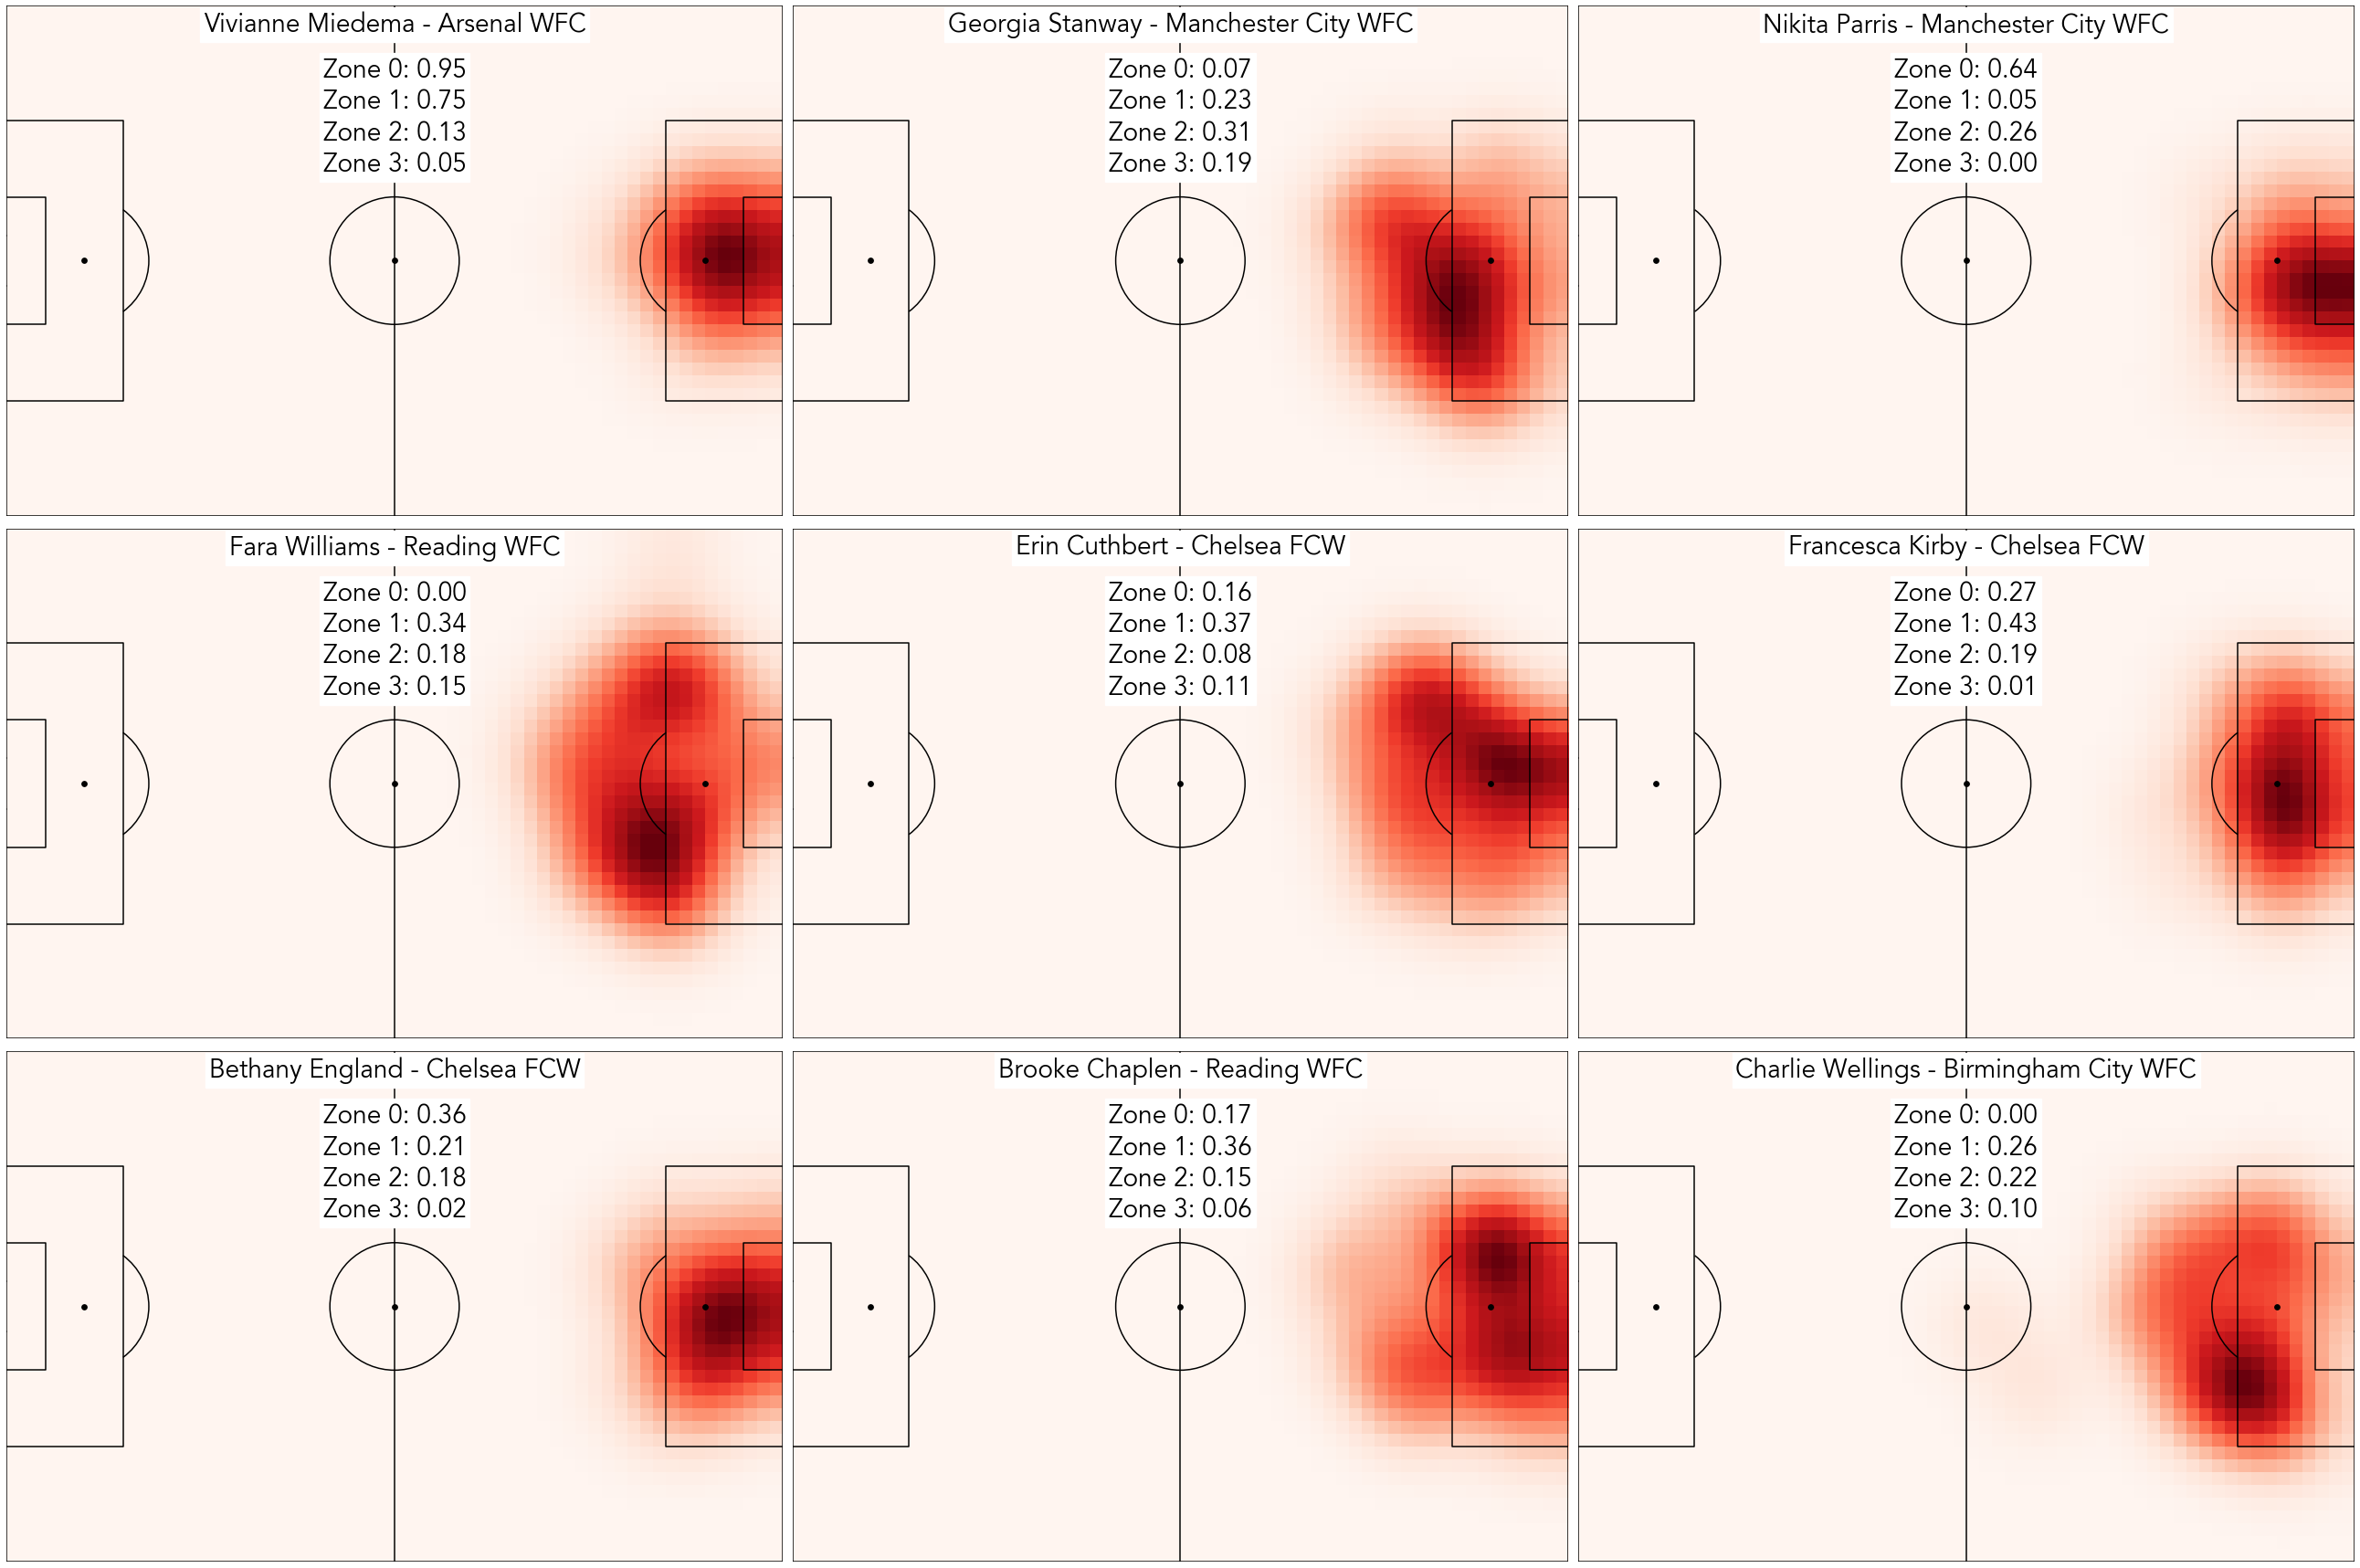

In [23]:
n_rows = 3
n_cols = 3
n_players = 9
fig, axs = plt.subplots(n_rows, n_cols, figsize=(36,8*n_rows))
count = 0
for i in range(n_rows):
    for j in range(n_cols):
        if count > n_players-1:
            axs[i, j].remove()
        else:
            _, ax = dp.draw_pitch('w','k','h','f',figax=(fig,axs[i,j]))
            ax.imshow(X[count].reshape(40,60), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
            ax.text(0.5,0.95,str(players_sht[count])+" - "+str(df_players.loc[players_sht[count]]['team']),
                    transform=ax.transAxes,fontsize=28,ha='center',backgroundcolor='w')
            ax.text(0.5,0.9,"Zone 0: {:.2f}".format(df_weights['Zone 0'].iloc[count])+
                    "\nZone 1: {:.2f}".format(df_weights['Zone 1'].iloc[count])+
                    "\nZone 2: {:.2f}".format(df_weights['Zone 2'].iloc[count])+
                    "\nZone 3: {:.2f}".format(df_weights['Zone 3'].iloc[count]),
                    transform=ax.transAxes,ha='center',va='top',
                    fontsize=28,backgroundcolor='w')
        count += 1
        
plt.tight_layout()

Who are the top players associated with each zone?

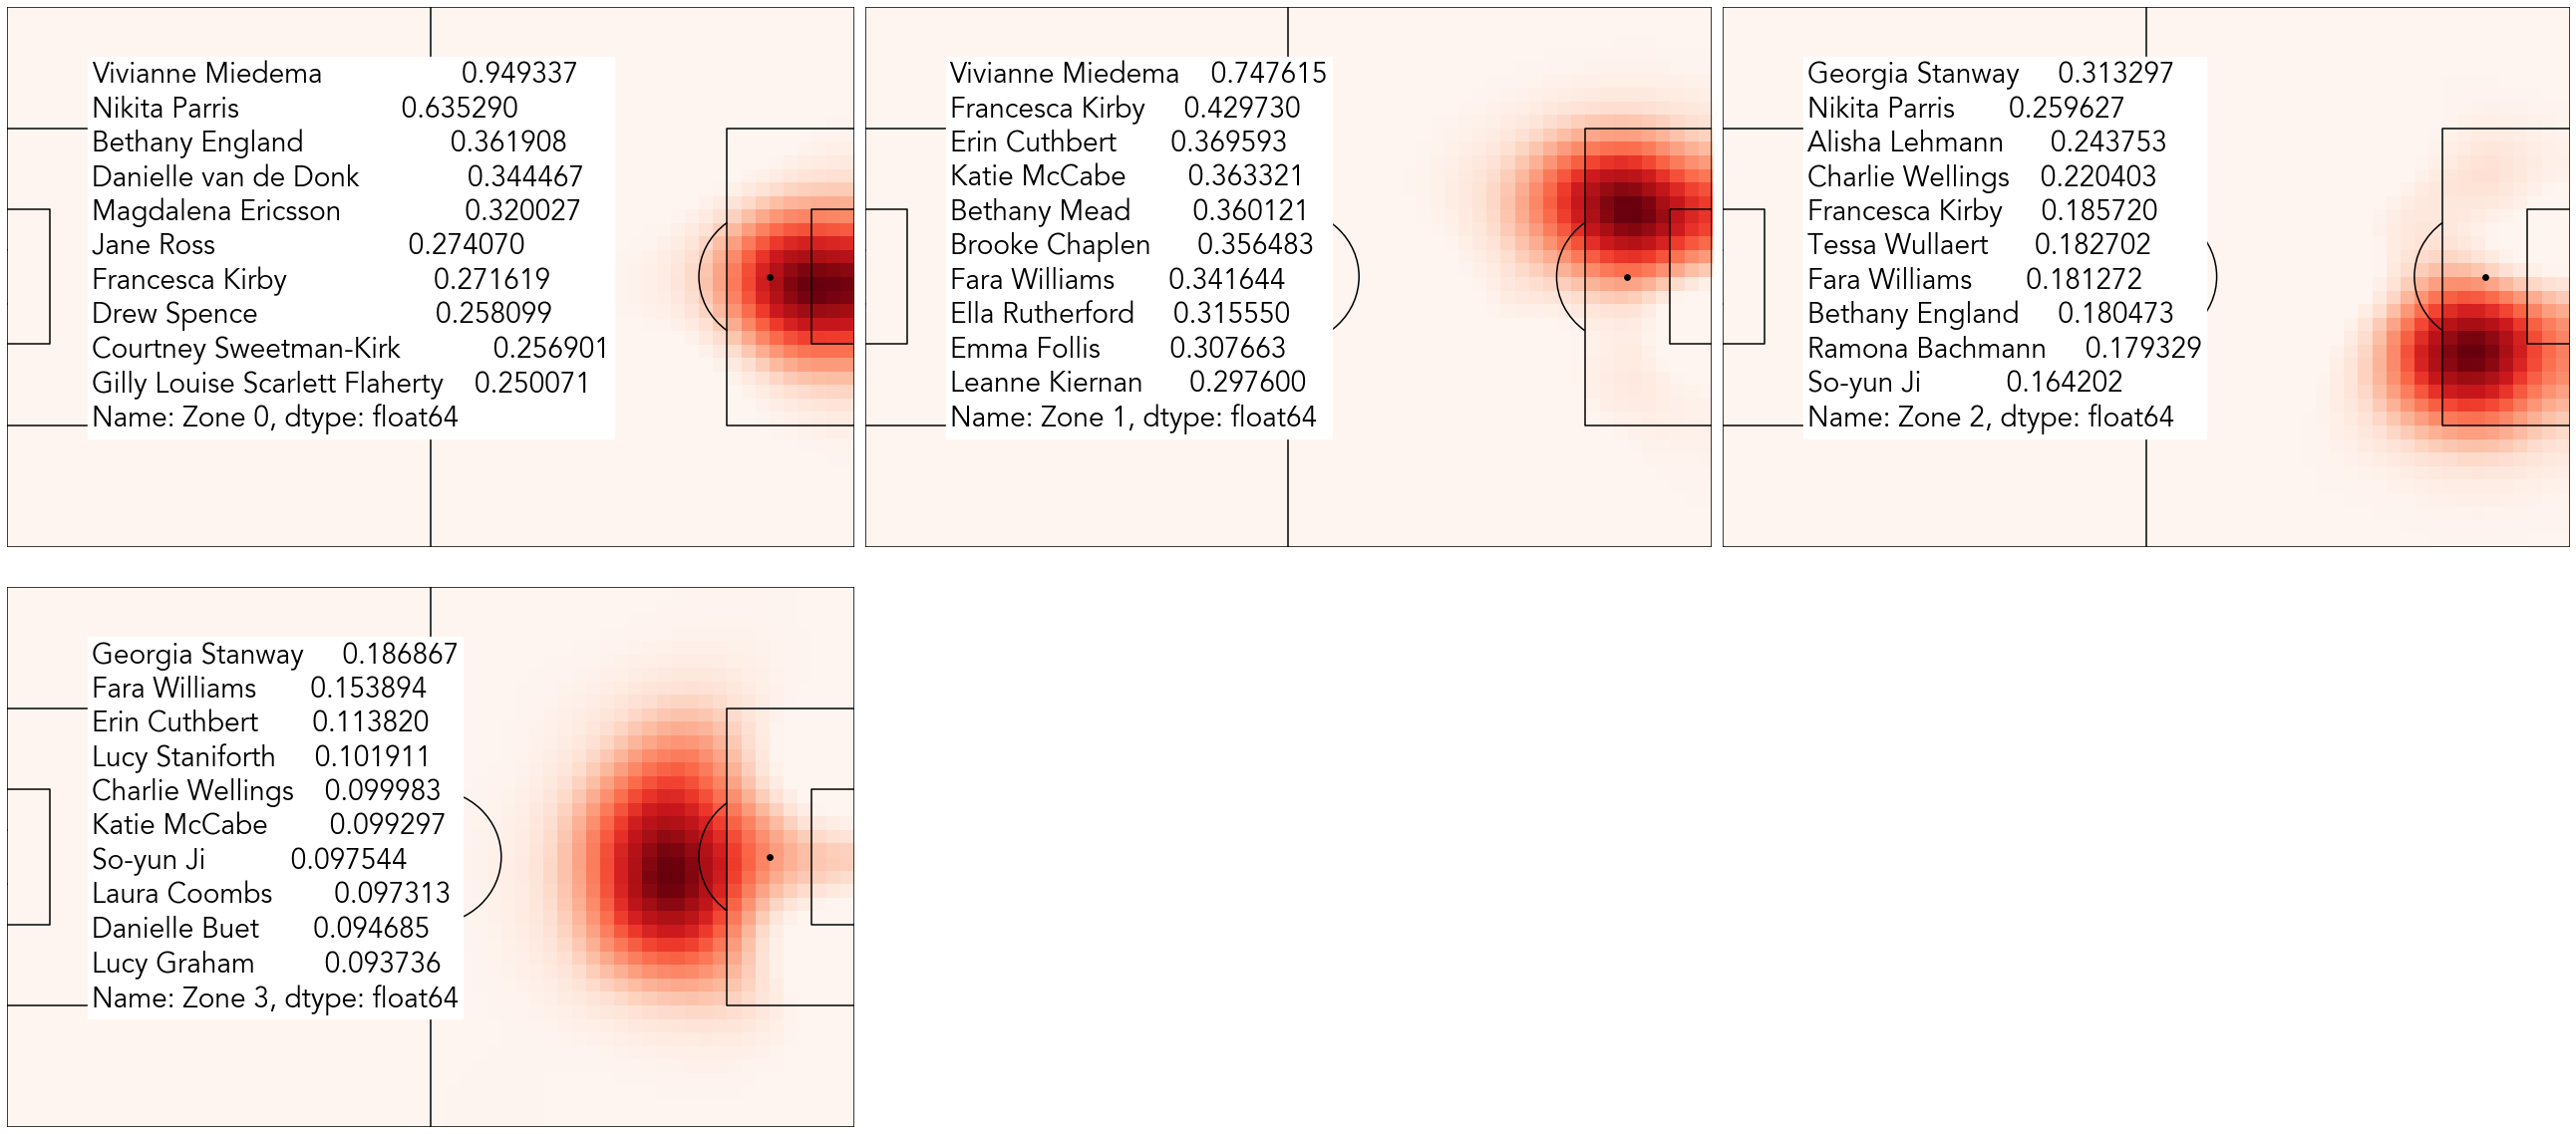

In [24]:
n_rows = 3
n_cols = 3
n_components = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(36,8*n_rows))
count = 0
for i in range(n_rows):
    for j in range(n_cols):
        if count > n_components-1:
            axs[i, j].remove()
        else:
            _, ax = dp.draw_pitch('w','k','h','f',figax=(fig,axs[i,j]))
            ax.imshow(H[count].reshape(40,60), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
            ax.text(0.1,0.9,str(df_weights['Zone {}'.format(count)].sort_values(ascending=False)[:10]),
                    transform=ax.transAxes,ha='left',va='top',
                    fontsize=28,backgroundcolor='w')
            
        count += 1
        
plt.tight_layout()

### Finding Similar Players

To find similar players, we can use the city block (Manhattan) distance between the player vectors.

In [25]:
from scipy.spatial.distance import cityblock

In [26]:
def find_similar(player, df_weights, players, num=5):
    dist = []
    val_player = df_weights.loc[player]
    for index,row in df_weights.iterrows():
        if player == index:
            continue
            
        dist.append(cityblock(val_player,row))
        
    df = pd.DataFrame({'dist':dist},index=players[1:])
    df.sort_values('dist',inplace=True)
    df = df.iloc[:num]
    
    return df

For example, who are the other players most similar to Miedema?

In [27]:
find_similar(players_sht[0], df_weights, players_sht)

,dist
Francesca Kirby,1.082458
Nikita Parris,1.187480
Bethany England,1.196863
Brooke Chaplen,1.199616
Erin Cuthbert,1.283025


## Passing

Read and sort the passing data.

In [28]:
df_pas = {}
for i in seasons:
    df_pas[str(i)] = [imsb.get_pass(match) for match in event_data[str(i)]]
    df_pas[str(i)] = pd.concat(df_pas[str(i)],ignore_index=True)
    df_pas[str(i)] = df_pas[str(i)][(df_pas[str(i)]['pass_type'] == "Standard")].copy()

The histogram of all passes. We see hotspots are goalkeeper, CBs and the wings - in particular, the right wing.

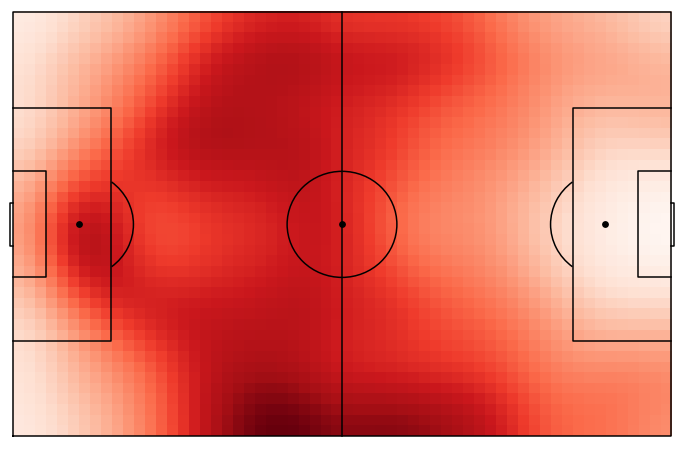

In [29]:
hist, ygrid, xgrid = np.histogram2d(df_pas['18/19']['y'],df_pas['18/19']['x'],bins=(40,60),range=[[0,80],[0,120]])
fig,ax = dp.draw_pitch('w','k','h','f')
ax.imshow(gaussian_filter(hist, 3), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)

Again order players by most passes then find the smoothed histogram for each.

In [30]:
players_pas = df_pas['18/19']['player'].value_counts().index

In [31]:
X_pas = np.zeros((len(players_pas), 40*60))
for i in range(len(players_pas)):
    df_player_pas = df_pas['18/19'][df_pas['18/19']['player'] == players_pas[i]]
    hist, *_ = np.histogram2d(df_player_pas['y'].values,df_player_pas['x'].values,bins=(40,60),range=[[0,80],[0,120]])
    X_pas[i] = gaussian_filter(hist,3).flatten()

Perform NMF using a hand-specified number of components.

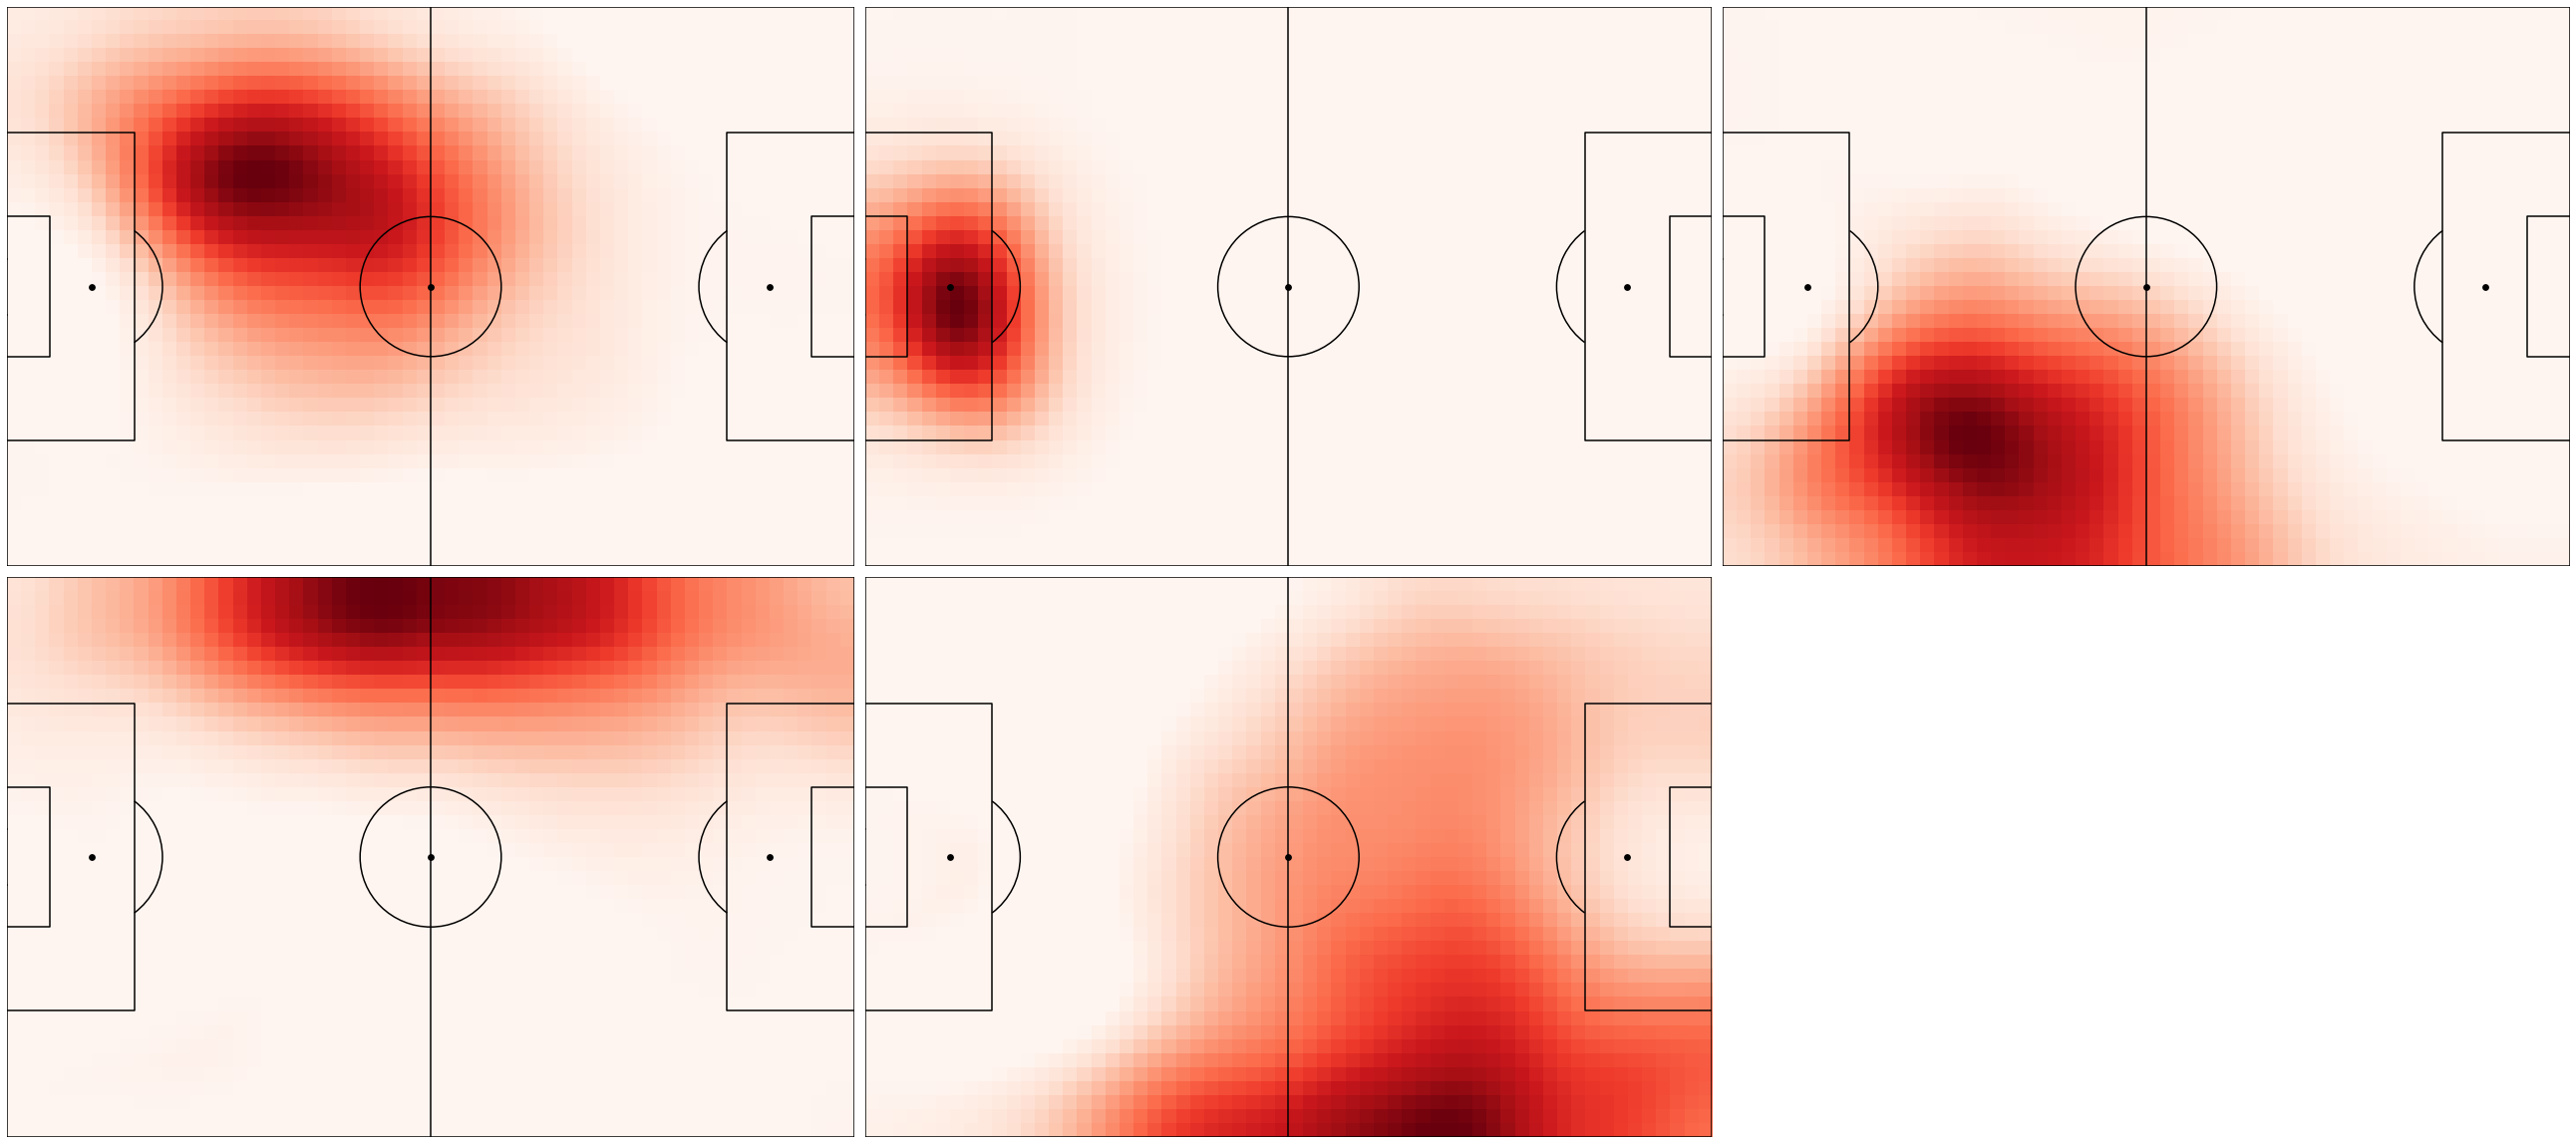

In [32]:
n_com = 5
model = skd.NMF(n_components=n_com, init='random', random_state=42)
W_pas = model.fit_transform(X_pas)
H_pas = model.components_

n_rows = 3
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(36,8*n_rows))
count = 0
for i in range(n_rows):
    for j in range(n_cols):
        if count > n_com-1:
            axs[i, j].remove()
        else:
            _, ax = dp.draw_pitch('w','k','h','f',figax=(fig,axs[i,j]))
            ax.imshow(H_pas[count].reshape(40,60), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
        count += 1
        
plt.tight_layout()

We see, as expected from the earlier heatmap of all passes, the zones are dominated by goalkeepers, centre backs and wide players. Hence, it may be more informative to look at different positions separately and compare within.

### Defenders

Begin by creating a dataframe of players who play in a defensive position ordered by the number of passes.

In [33]:
# Create dataframe of all def player passes
df_list = []
for i in range(len(df_def)):
    df_list.append(df_pas['18/19'][df_pas['18/19']['player'] == df_def.index[i]])
    
players_pas_def = pd.concat(df_list)['player'].value_counts().index;

In [34]:
# Dataframe of CB players ordered by number of passes (descending)
df_def_pas = df_def.loc[players_pas_def];

Calculate the heatmap of each individual player then perform NMF and show the resulting components.

In [35]:
X_def = np.zeros((len(df_def_pas), 40*60))
for i in range(len(df_def_pas)):
    df_player_pas = df_pas['18/19'][df_pas['18/19']['player'] == df_def_pas.index[i]]
    hist, *_ = np.histogram2d(df_player_pas['y'].values,df_player_pas['x'].values,bins=(40,60),range=[[0,80],[0,120]])
    X_def[i] = gaussian_filter(hist,3).flatten()

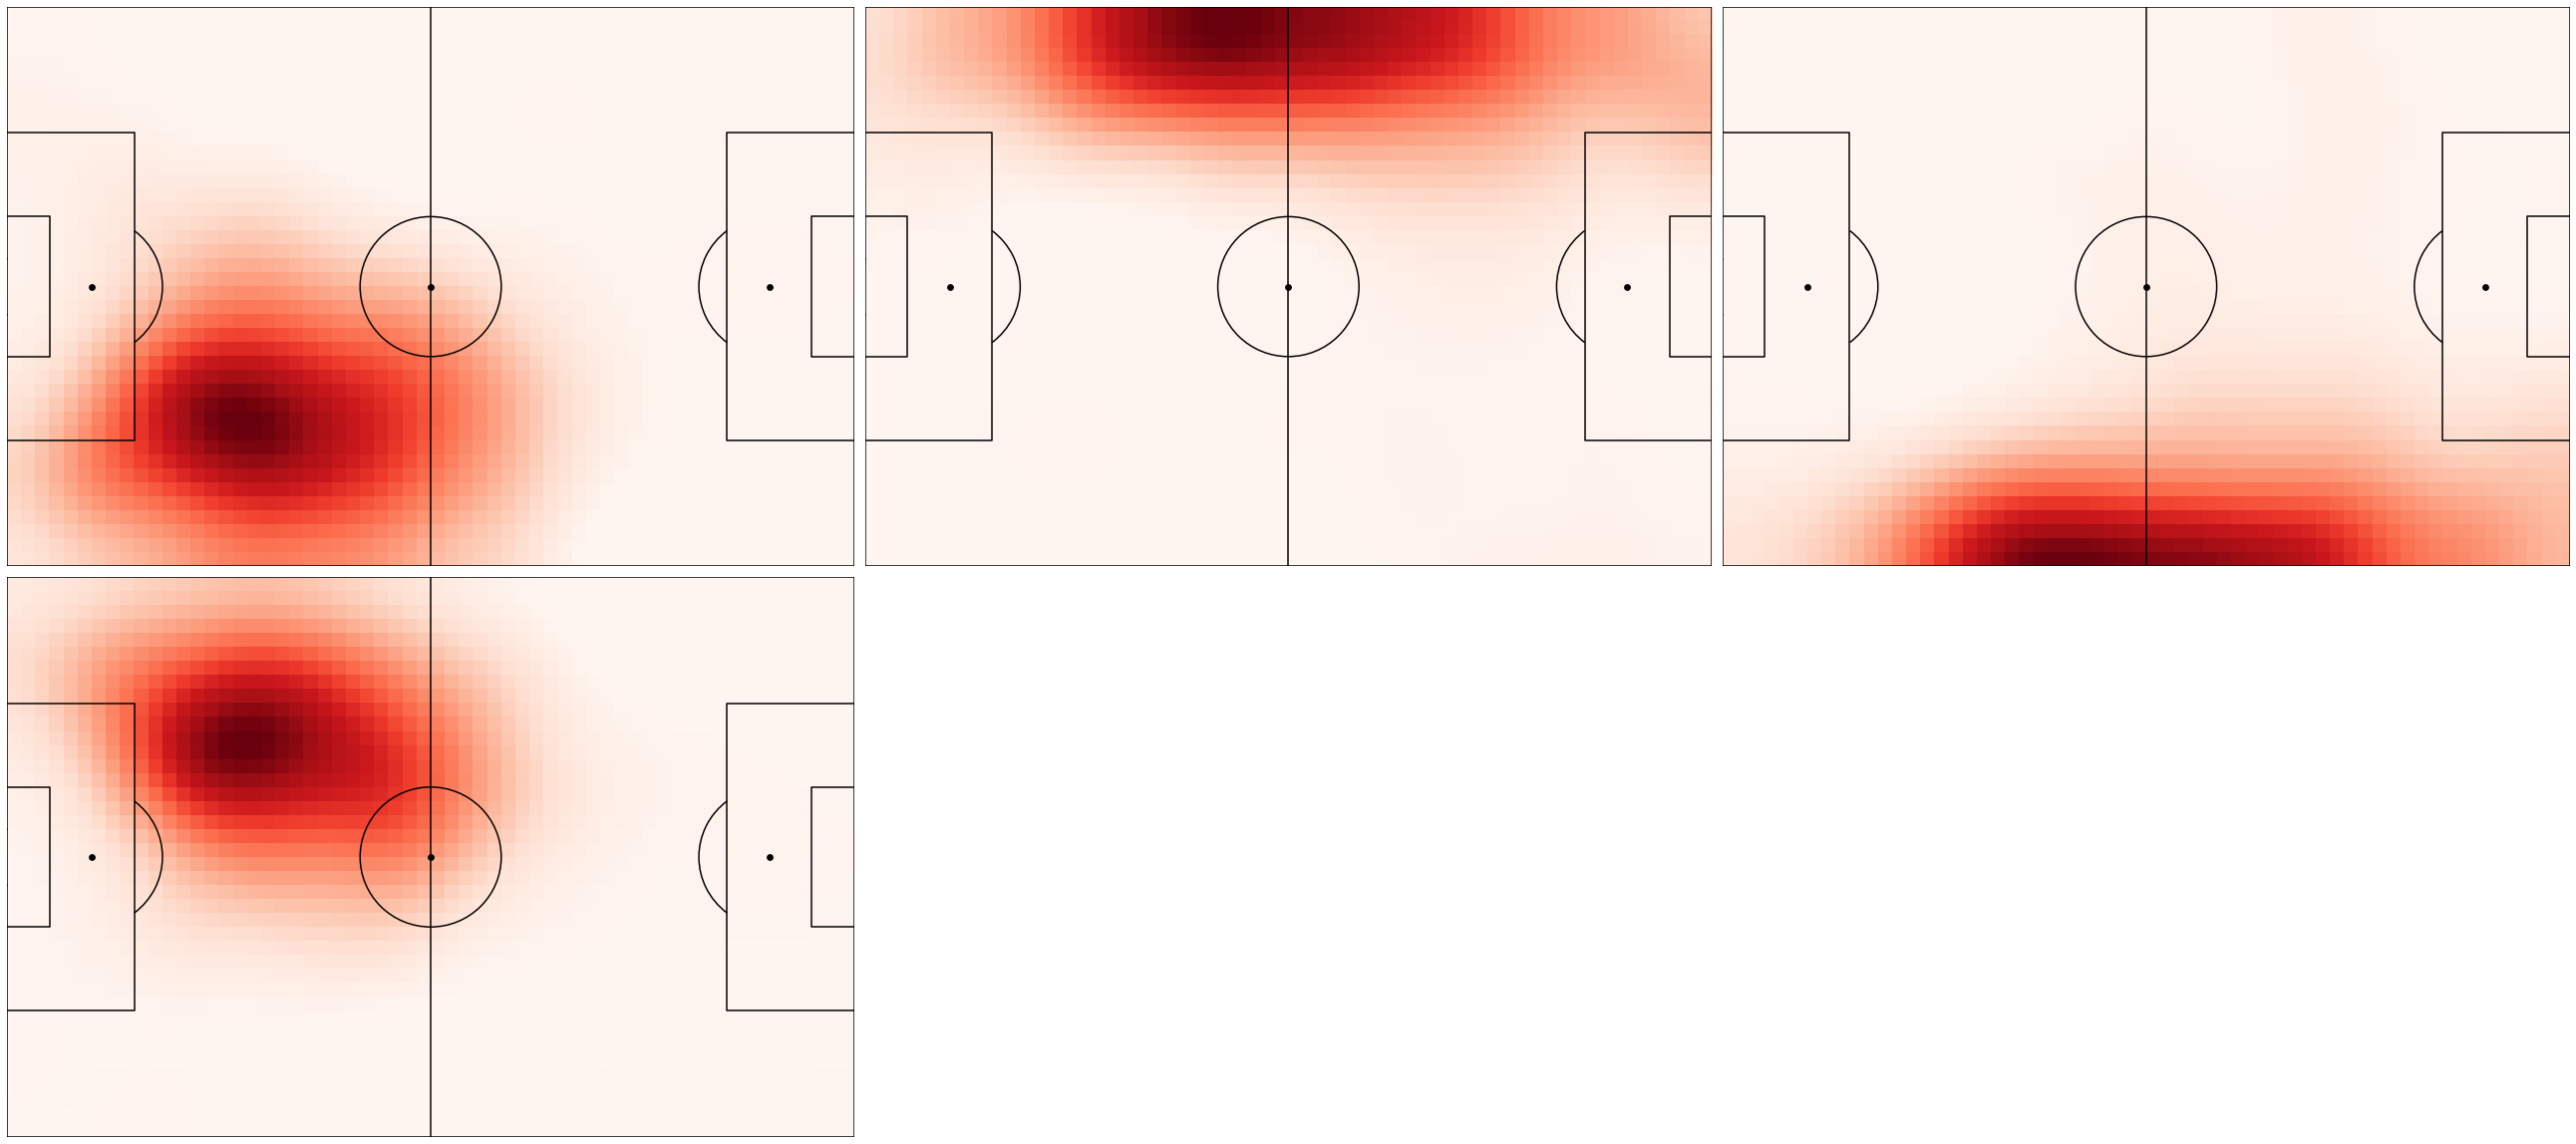

In [36]:
n_com = 4
model = skd.NMF(n_components=n_com, init='random', random_state=42)
W_def = model.fit_transform(X_def)
H_def = model.components_

n_rows = 3
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(36,8*n_rows))
count = 0
for i in range(n_rows):
    for j in range(n_cols):
        if count > n_com-1:
            axs[i, j].remove()
        else:
            _, ax = dp.draw_pitch('w','k','h','f',figax=(fig,axs[i,j]))
            ax.imshow(H_def[count].reshape(40,60), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
        count += 1
        
plt.tight_layout()

We see clearly defined RCB, LCB, RB and LB zones.

Who are the players most associated with each zone?

In [37]:
df_weights_def_pas = pd.DataFrame(W_def, index=df_def_pas.index, columns=['Zone {}'.format(i) for i in range(n_com)])

In [38]:
[df_weights_def_pas['Zone {}'.format(i)].sort_values(ascending=False)[:5] for i in range(n_com)]

[Stephanie Houghton    2.484511
 Leah Williamson       2.062580
 Millie Bright         1.702838
 Kirstyn Pearce        1.605135
 Aoife Mannion         1.430836
 Name: Zone 0, dtype: float64,
 Jonna Andersson    2.072631
 Demi Stokes        1.215233
 Emma Mitchell      1.172369
 Mayumi Pacheco     1.048862
 Katie McCabe       1.015023
 Name: Zone 1, dtype: float64,
 Lisa Evans               1.485796
 Hannah Jayne Blundell    1.418277
 Gemma Bonner             1.055374
 Natasha Harding          1.008226
 Kirsty Barton            0.943074
 Name: Zone 2, dtype: float64,
 Jennifer Beattie      1.734508
 Magdalena Ericsson    1.496832
 Louise Quinn          1.475058
 Josanne Potter        1.134070
 Aoife Mannion         0.875619
 Name: Zone 3, dtype: float64]

### Central Defenders

What about if we just focus on central defenders?

In [39]:
# Create dataframe of all CB player passes
df_list = []
for i in range(len(df_cdef)):
    df_list.append(df_pas['18/19'][df_pas['18/19']['player'] == df_cdef.index[i]])
    
players_pas_cdef = pd.concat(df_list)['player'].value_counts().index;

In [40]:
# Dataframe of CB players ordered by number of passes (descending)
df_cdef_pas = df_cdef.loc[players_pas_cdef];

Calculate and plot the components.

In [41]:
X_cdef = np.zeros((len(df_cdef_pas), 40*60))
for i in range(len(df_cdef_pas)):
    df_player_pas = df_pas['18/19'][df_pas['18/19']['player'] == df_cdef_pas.index[i]]
    hist, *_ = np.histogram2d(df_player_pas['y'].values,df_player_pas['x'].values,bins=(40,60),range=[[0,80],[0,120]])
    X_cdef[i] = gaussian_filter(hist,3).flatten()

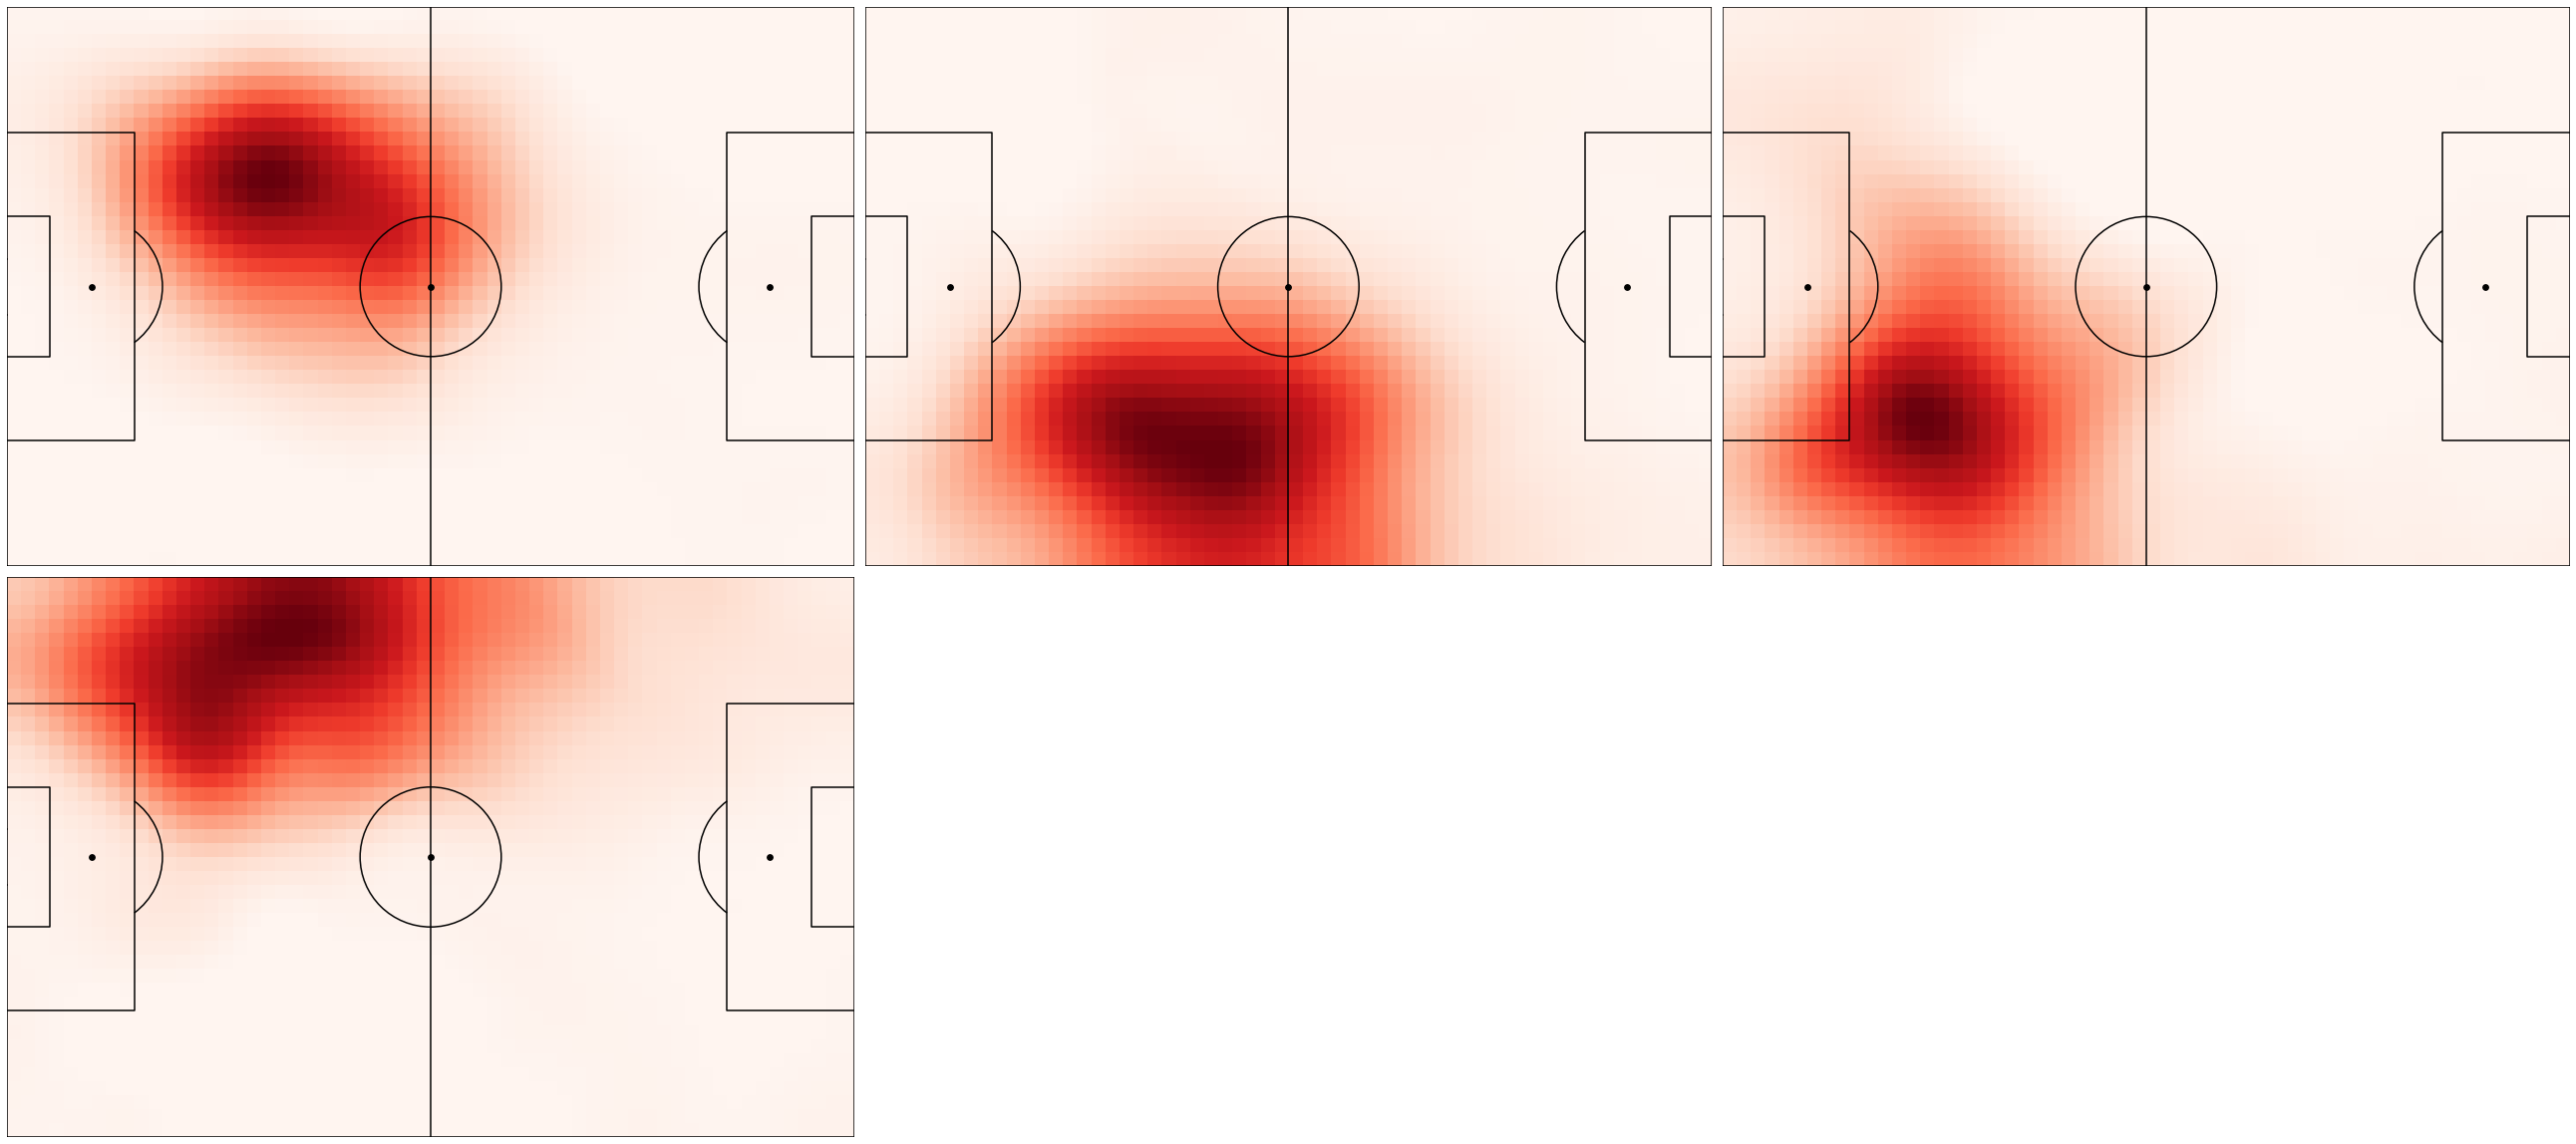

In [42]:
n_com = 4
model = skd.NMF(n_components=n_com, init='random', random_state=42)
W_cdef = model.fit_transform(X_cdef)
H_cdef = model.components_

n_rows = 3
n_cols = 3
n_components = n_com
fig, axs = plt.subplots(n_rows, n_cols, figsize=(36,8*n_rows))
count = 0
for i in range(n_rows):
    for j in range(n_cols):
        if count > n_components-1:
            axs[i, j].remove()
        else:
            _, ax = dp.draw_pitch('w','k','h','f',figax=(fig,axs[i,j]))
            ax.imshow(H_cdef[count].reshape(40,60), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
        count += 1
        
plt.tight_layout()

We see LCB and RCB zones (zones 0 and 3) but also wider zones.

### Central Midfielders

It will be interesting to try to find similar players across the numerous midfield roles.

In [43]:
# Create dataframe of all CM player passes
df_list = []
for i in range(len(df_cmid)):
    df_list.append(df_pas['18/19'][df_pas['18/19']['player'] == df_cmid.index[i]])
    
players_pas_cmid = pd.concat(df_list)['player'].value_counts().index;

In [44]:
# Dataframe of CM players ordered by number of passes (descending)
df_cmid_pas = df_cmid.loc[players_pas_cmid];

In [45]:
X_cmid = np.zeros((len(df_cmid_pas), 40*60))
for i in range(len(df_cmid_pas)):
    df_player_pas = df_pas['18/19'][df_pas['18/19']['player'] == df_cmid_pas.index[i]]
    hist, *_ = np.histogram2d(df_player_pas['y'].values,df_player_pas['x'].values,bins=(40,60),range=[[0,80],[0,120]])
    X_cmid[i] = gaussian_filter(hist,3).flatten()

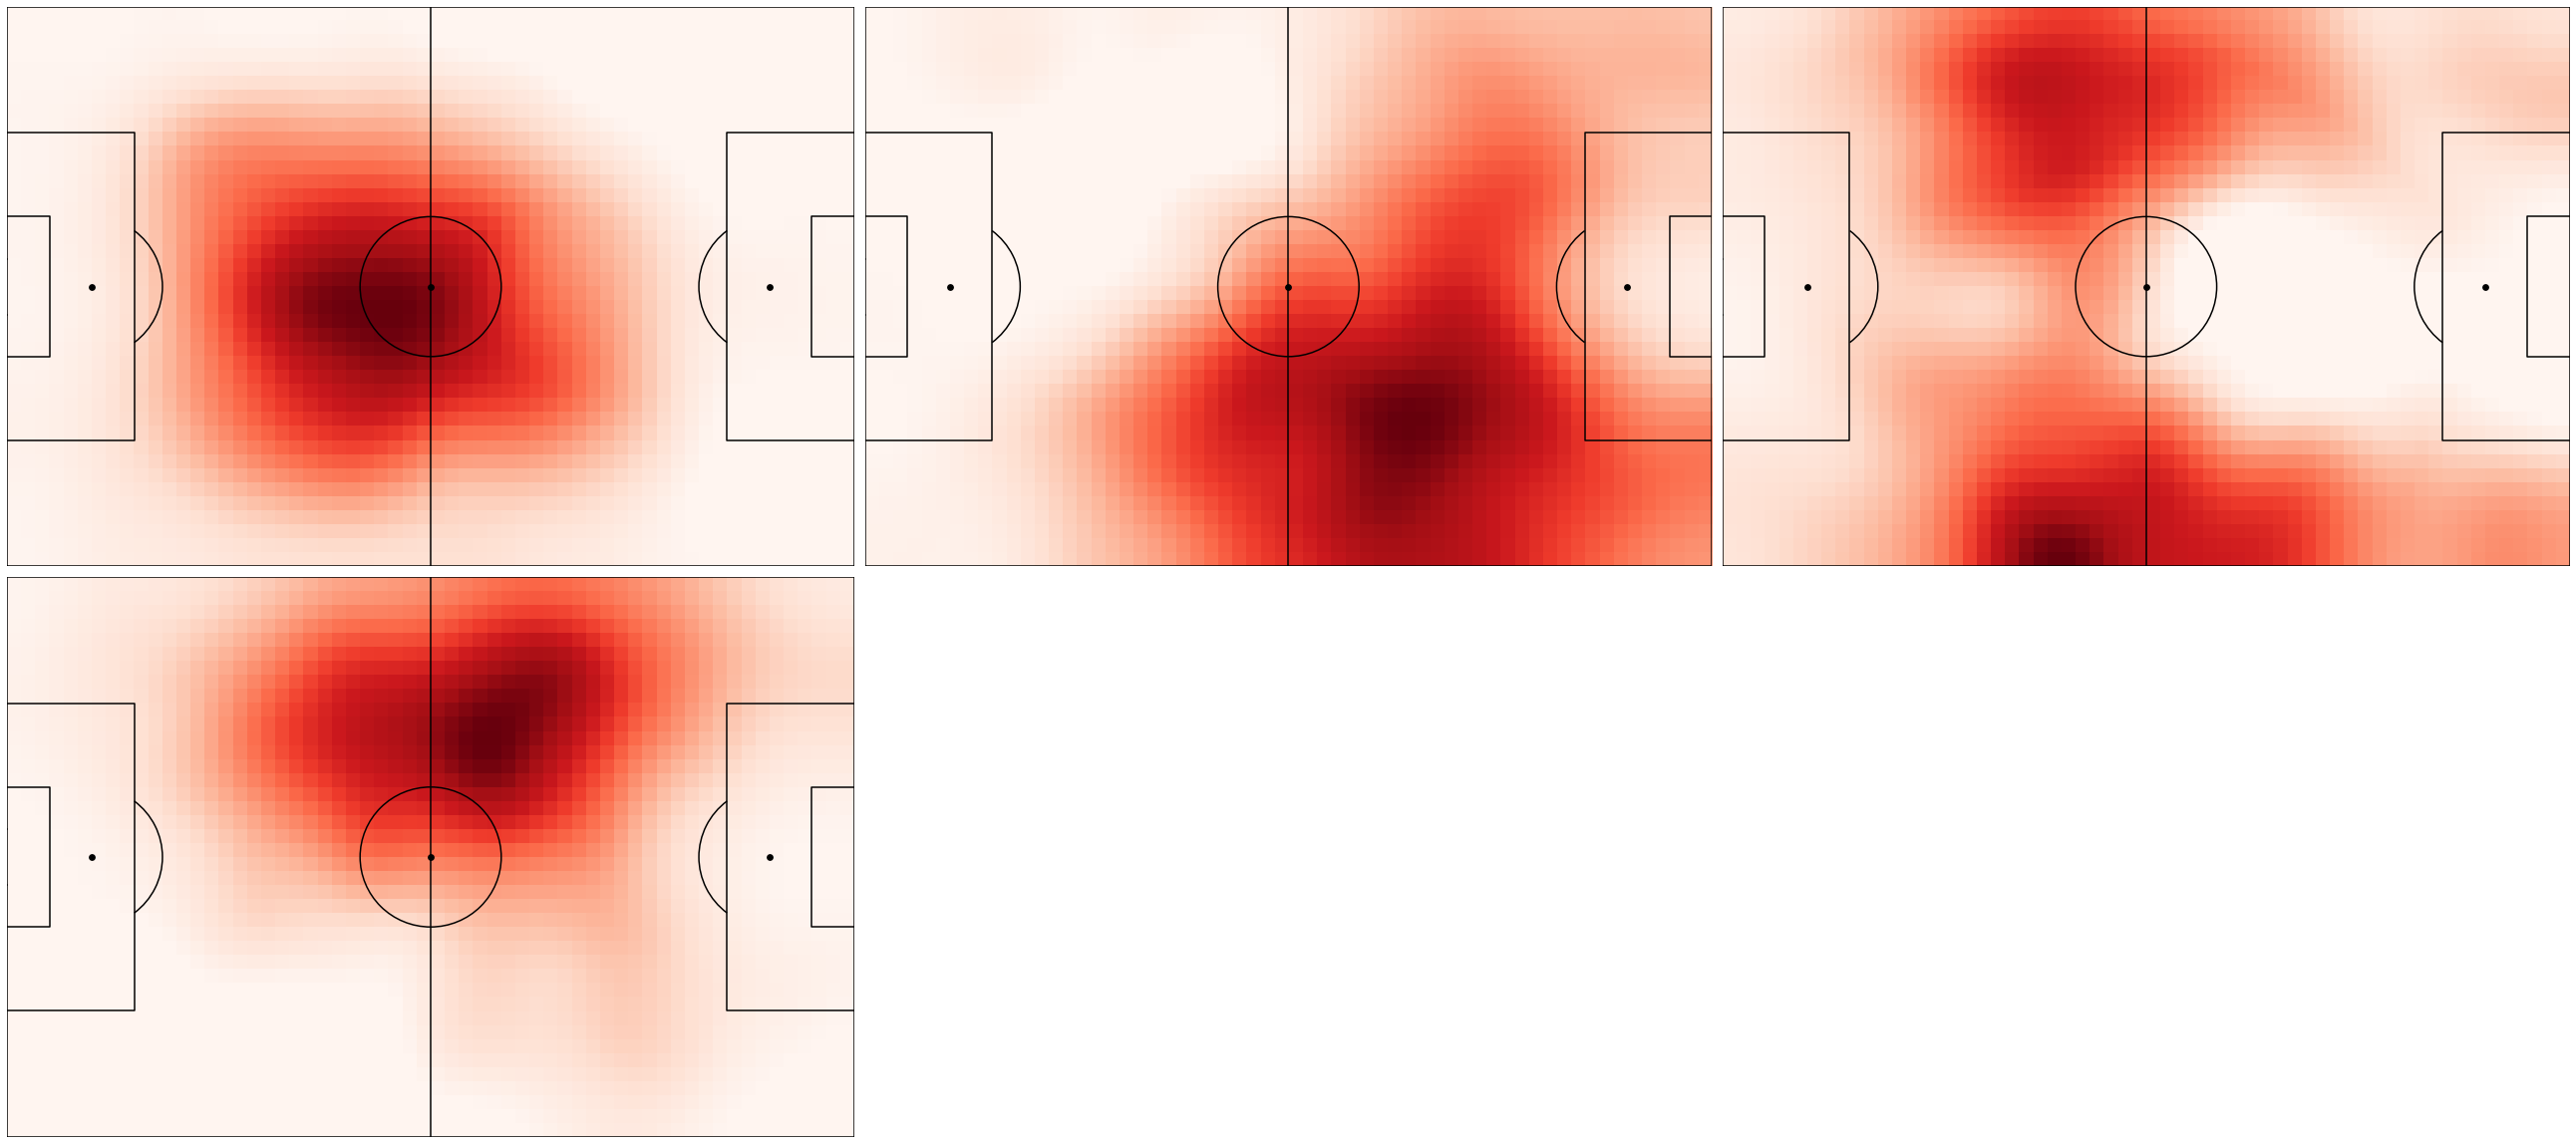

In [46]:
n_com = 4
model = skd.NMF(n_components=n_com, init='random', random_state=42)
W_cmid = model.fit_transform(X_cmid)
H_cmid = model.components_

n_rows = 3
n_cols = 3
n_components = n_com
fig, axs = plt.subplots(n_rows, n_cols, figsize=(36,8*n_rows))
count = 0
for i in range(n_rows):
    for j in range(n_cols):
        if count > n_components-1:
            axs[i, j].remove()
        else:
            _, ax = dp.draw_pitch('w','k','h','f',figax=(fig,axs[i,j]))
            ax.imshow(H_cmid[count].reshape(40,60), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
        count += 1
        
plt.tight_layout()

Four zones seems to work ok but there is the right-sided bias. There are vague zones for CM/CDM, RAM, Wing Back, LAM.

Who is most associated with each zone?

In [47]:
df_weights_cmid = pd.DataFrame(W_cmid, index=df_cmid_pas.index, columns=['Zone {}'.format(i) for i in range(n_com)])

In [48]:
[df_weights_cmid['Zone {}'.format(i)].sort_values(ascending=False)[:5] for i in range(n_com)]

[Dominique Johanna Anna Bloodworth    1.210034
 Hayley Ladd                          1.058684
 Keira Walsh                          0.957273
 Rachel Furness                       0.775340
 Angharad James                       0.767443
 Name: Zone 0, dtype: float64,
 So-yun Ji          1.311839
 Lucy Staniforth    1.112803
 Jill Scott         1.079761
 Kim Little         1.021744
 Fara Williams      0.939265
 Name: Zone 1, dtype: float64,
 Lucy Graham        0.553851
 Chloe Peplow       0.481979
 Chloe Arthur       0.463622
 Lucy Staniforth    0.451828
 Kate Longhurst     0.444169
 Name: Zone 2, dtype: float64,
 Keira Walsh       1.367915
 Lia Wälti         0.580997
 So-yun Ji         0.506490
 Inessa Kaagman    0.391542
 Fara Williams     0.352931
 Name: Zone 3, dtype: float64]

In [49]:
# Function for plotting text with a players association to each zone
def player_zone_ratings(zone_num, weights, player):
    string = ""
    for i in range(zone_num):
        string += "Zone {}: {:.2f}\n".format(i,weights['Zone {}'.format(i)].iloc[player])
    return string

Looking at the distributions of the nine players who have passed the most.

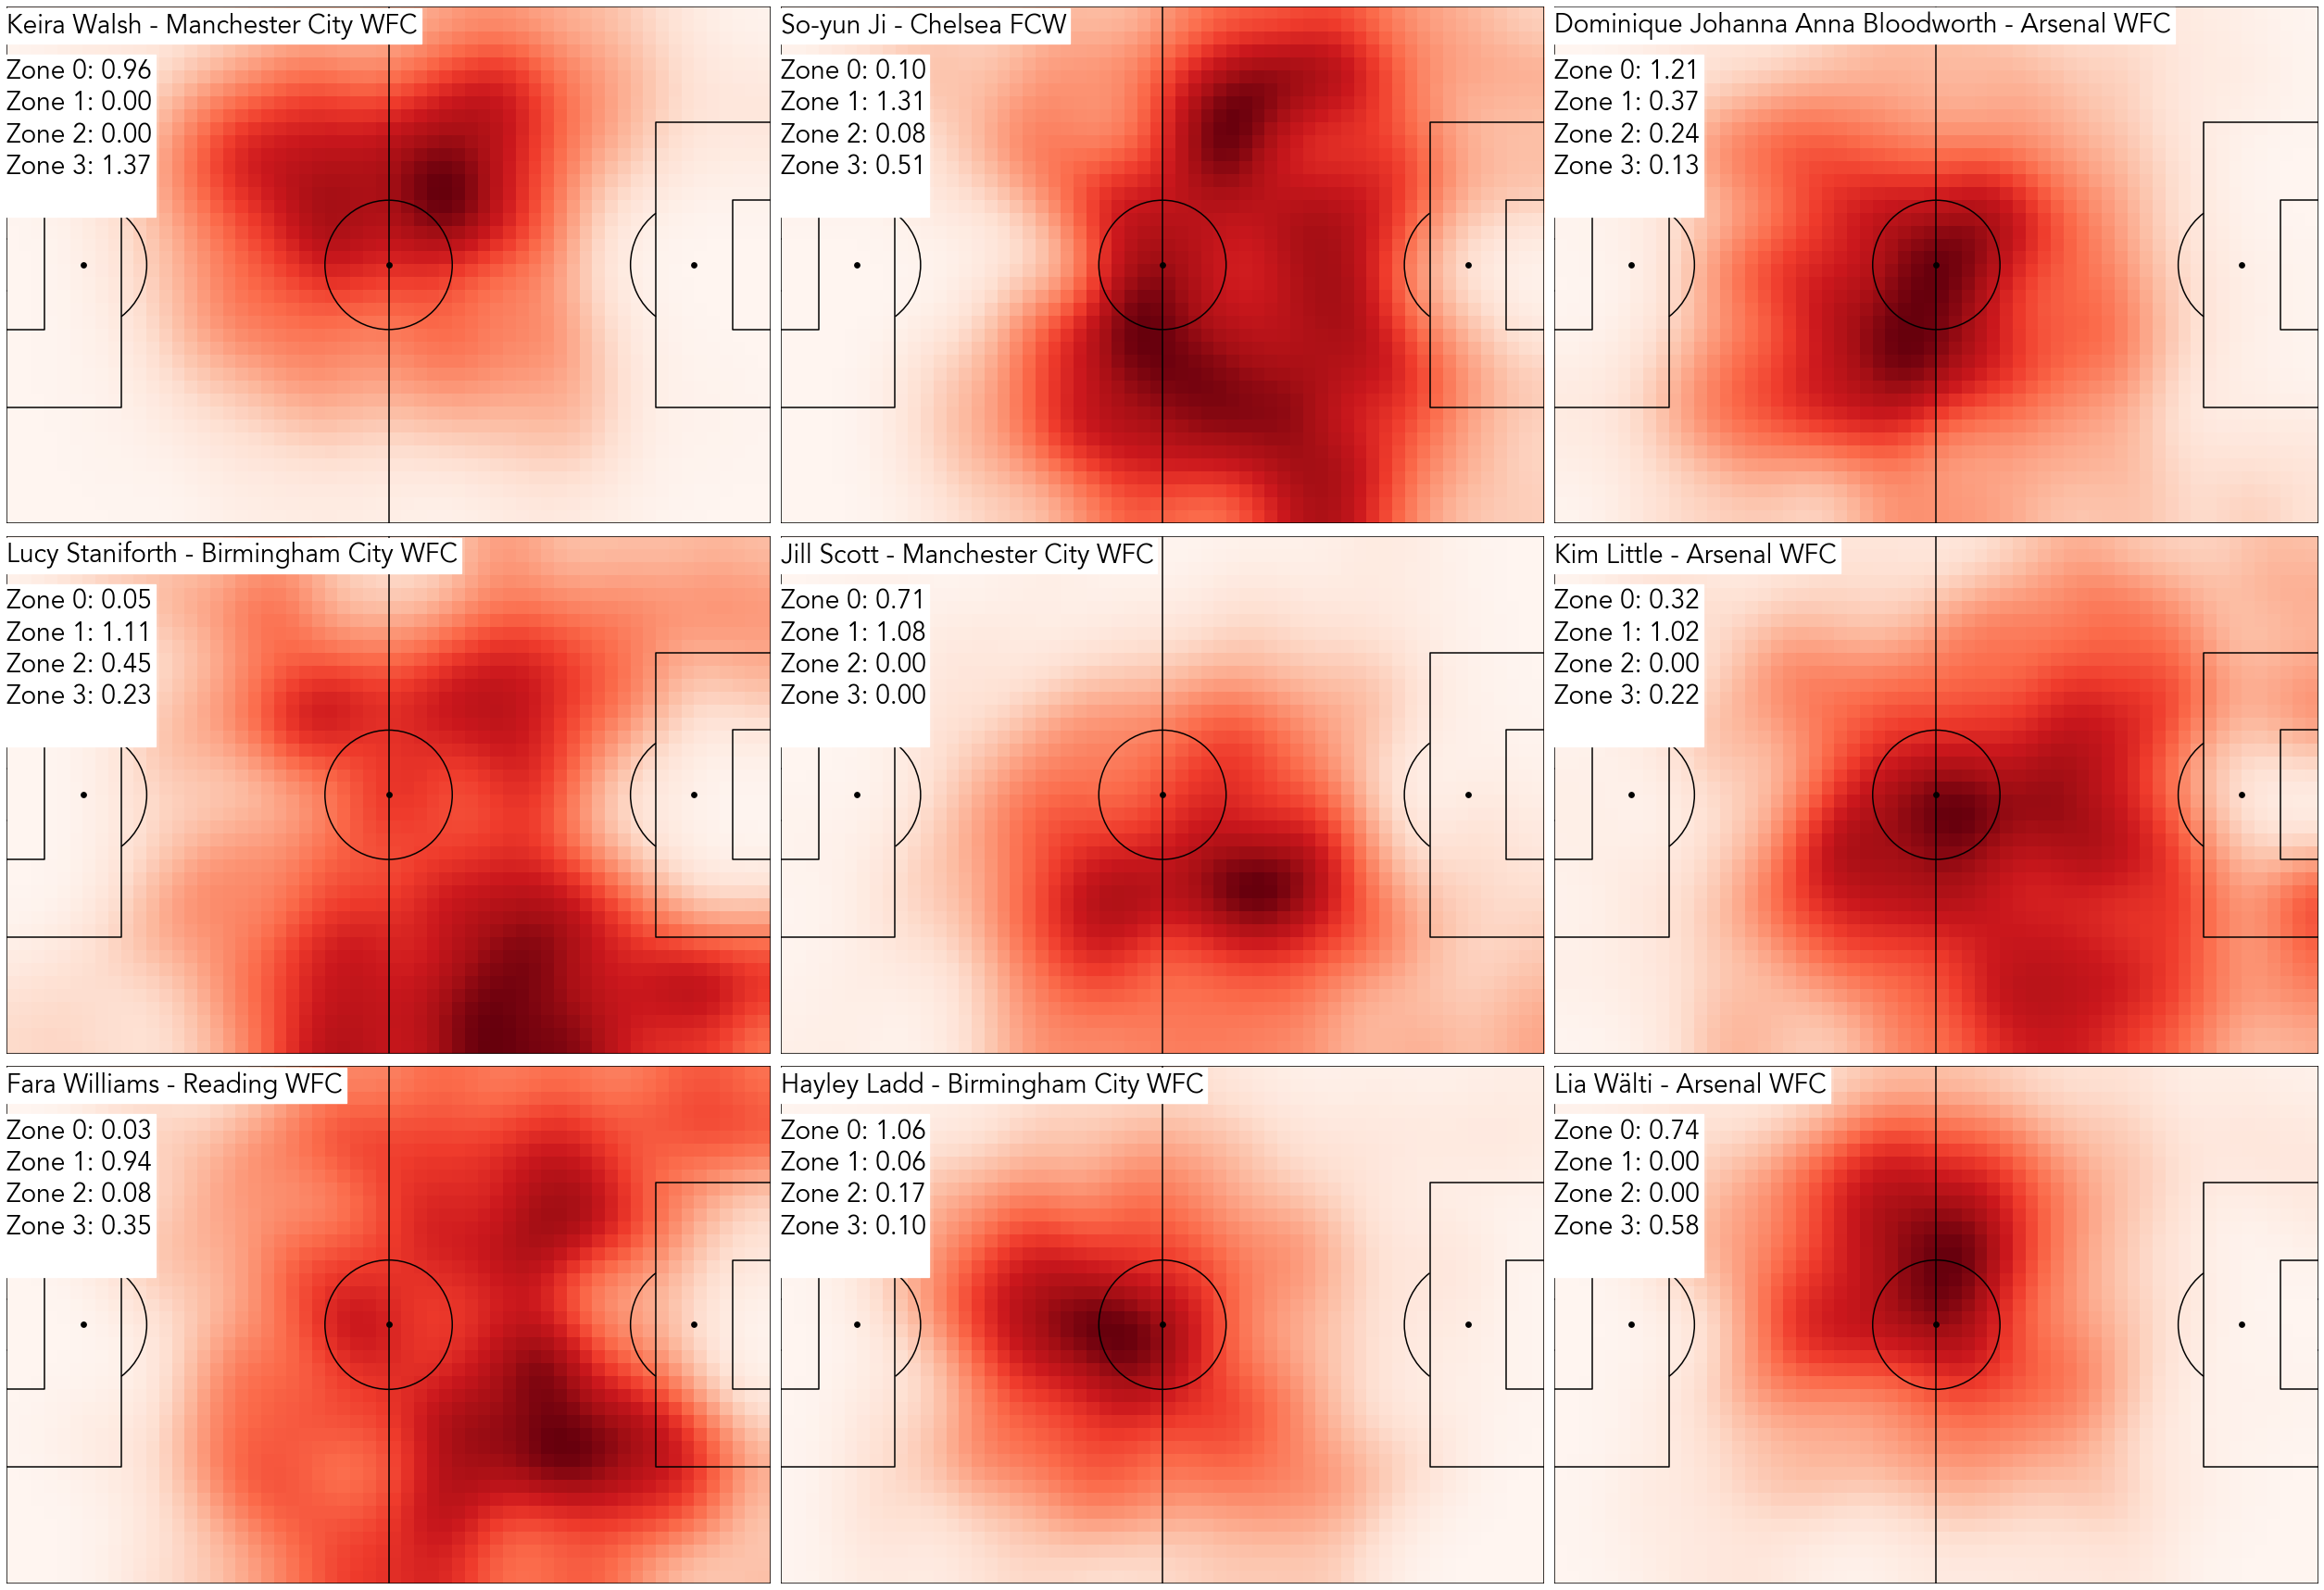

In [50]:
n_rows = 3
n_cols = 3
n_players = 9
fig, axs = plt.subplots(n_rows, n_cols, figsize=(36,8*n_rows))
count = 0
for i in range(n_rows):
    for j in range(n_cols):
        if count > n_players-1:
            axs[i, j].remove()
        else:
            _, ax = dp.draw_pitch('w','k','h','f',figax=(fig,axs[i,j]))
            ax.imshow(X_cmid[count].reshape(40,60), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
            ax.text(0.,0.95,str(df_cmid_pas.index[count])+" - "+str(df_cmid_pas['team'][count]),
                    transform=ax.transAxes,fontsize=28,
                    ha='left',backgroundcolor='w')
            ax.text(0.,0.9,player_zone_ratings(n_com,df_weights_cmid,count),
                    transform=ax.transAxes,ha='left',va='top',
                    fontsize=28,backgroundcolor='w')
        count += 1
        
plt.tight_layout()

What if we want to find a player similar to Jill Scott?

In [51]:
sim = find_similar("Jill Scott", df_weights_cmid, df_cmid_pas.index, num=5)
sim

,dist
Kim Little,0.666983
Sophie Ingle,1.004046
Laura Coombs,1.223030
Fara Williams,1.257575
Rachel Furness,1.343729


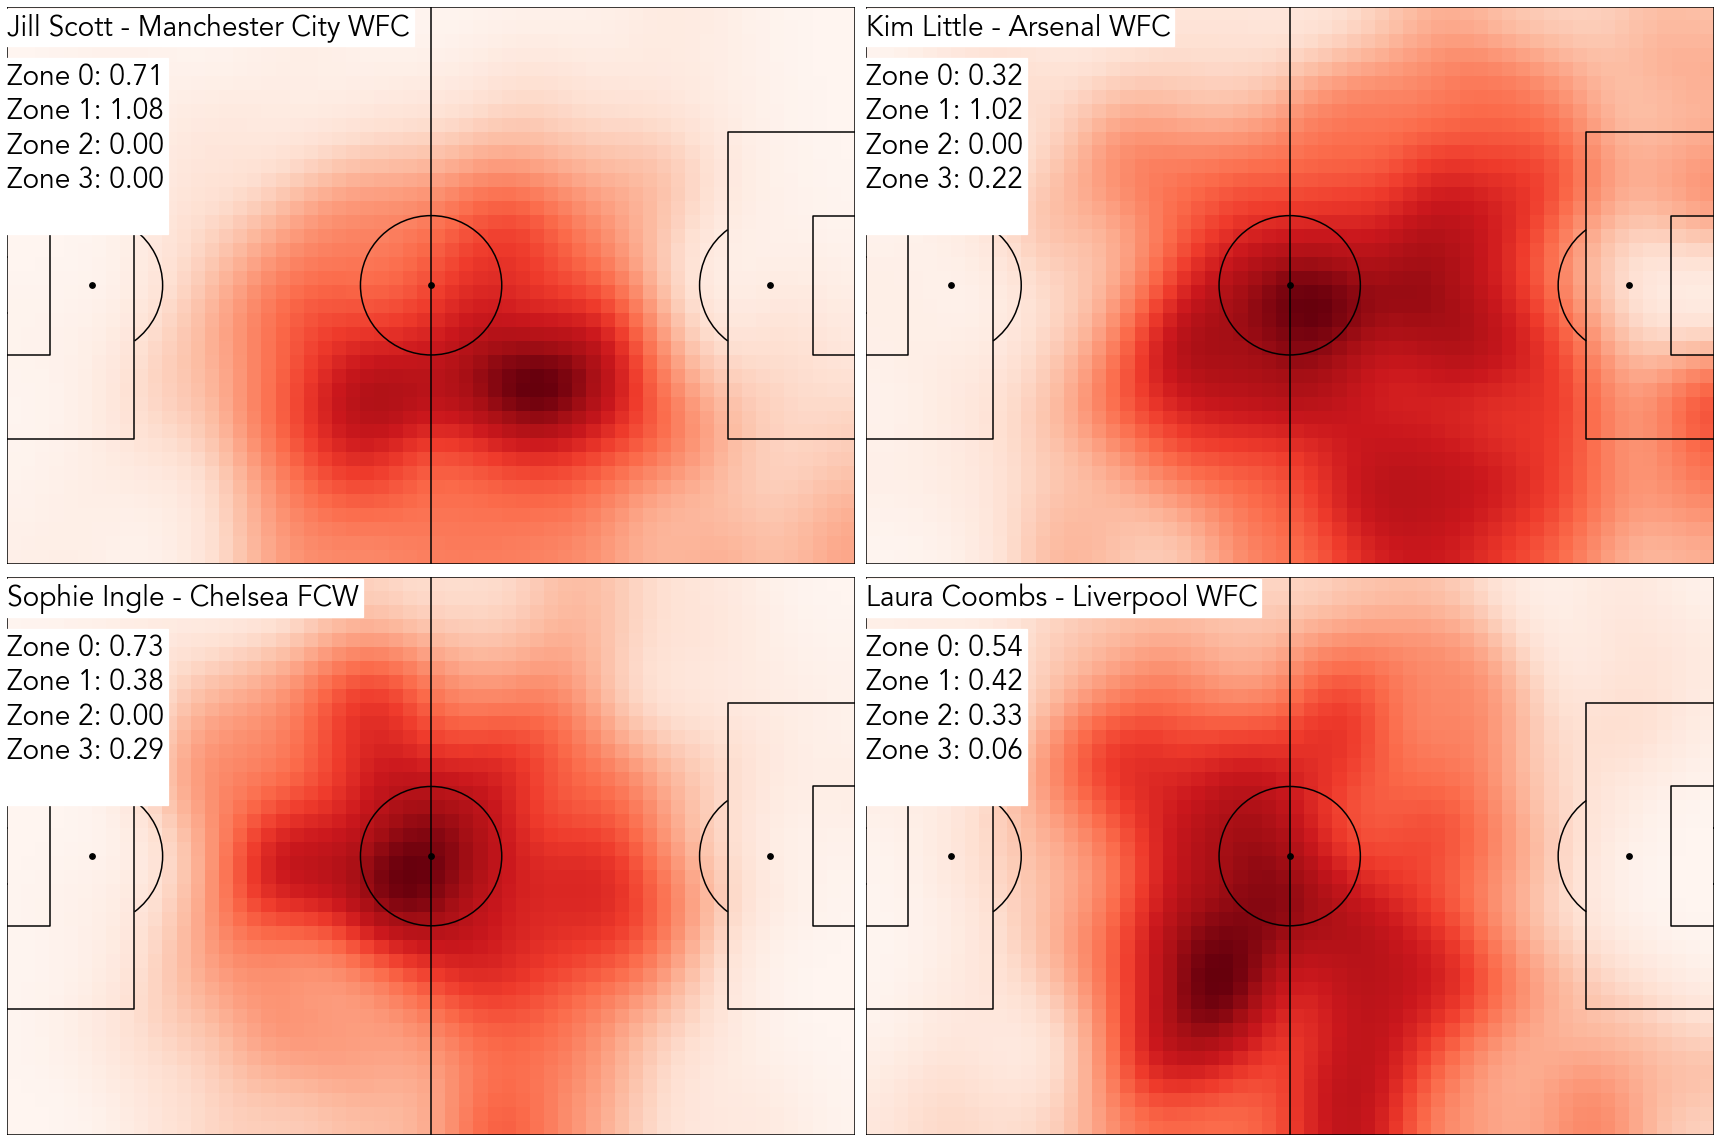

In [52]:
n_rows = 2
n_cols = 2
n_players = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12*n_cols,8*n_rows))
player_ids = [df_cmid_pas.index.get_loc('Jill Scott')] + [df_cmid_pas.index.get_loc(i) for i in sim.index]
player_ids = player_ids[:n_players]
count = 0
for i in range(n_rows):
    for j in range(n_cols):
        _, ax = dp.draw_pitch('w','k','h','f',figax=(fig,axs[i,j]))
        ax.imshow(X_cmid[player_ids[count]].reshape(40,60), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
        ax.text(0.,0.95,str(df_cmid_pas.index[player_ids[count]])+" - "+str(df_cmid_pas['team'][player_ids[count]]),
                transform=ax.transAxes,fontsize=28,
                ha='left',backgroundcolor='w')
        ax.text(0.,0.9,player_zone_ratings(n_com,df_weights_cmid,player_ids[count]),
                transform=ax.transAxes,ha='left',va='top',
                fontsize=28,backgroundcolor='w')
        count += 1
        
plt.tight_layout()

## Progressive Carries

In [53]:
df_car = {}
for i in seasons:
    df_car[str(i)] = [imsb.get_carry_prog(match) for match in event_data[str(i)]]
    df_car[str(i)] = pd.concat(df_car[str(i)],ignore_index=True)

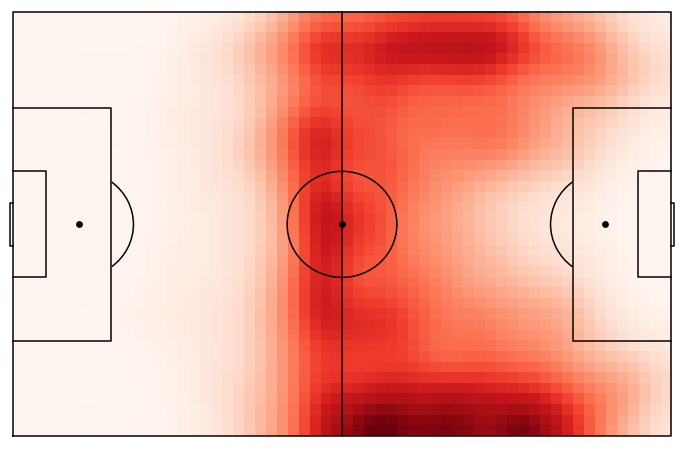

In [54]:
hist, ygrid, xgrid = np.histogram2d(df_car['18/19']['y'],df_car['18/19']['x'],bins=(40,60),range=[[0,80],[0,120]])
fig,ax = dp.draw_pitch('w','k','h','f')
ax.imshow(gaussian_filter(hist, 2), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)

In [55]:
players_car = df_car['18/19']['player'].value_counts().index

### Central Midfielders

In [56]:
# Create dataframe of all CM player carries
df_list = []
for i in range(len(df_cmid)):
    df_list.append(df_car['18/19'][df_car['18/19']['player'] == df_cmid.index[i]])
    
players_car_cmid = pd.concat(df_list)['player'].value_counts().index;

In [57]:
# Dataframe of CM players ordered by number of progressive carries (descending)
df_cmid_car = df_cmid.loc[players_car_cmid];

In [58]:
X_cmid_car = np.zeros((len(df_cmid_car), 40*60))
for i in range(len(df_cmid_car)):
    df_player_car = df_car['18/19'][df_car['18/19']['player'] == df_cmid_car.index[i]]
    hist, *_ = np.histogram2d(df_player_car['y'].values,df_player_car['x'].values,bins=(40,60),range=[[0,80],[0,120]])
    X_cmid_car[i] = gaussian_filter(hist,5).flatten()

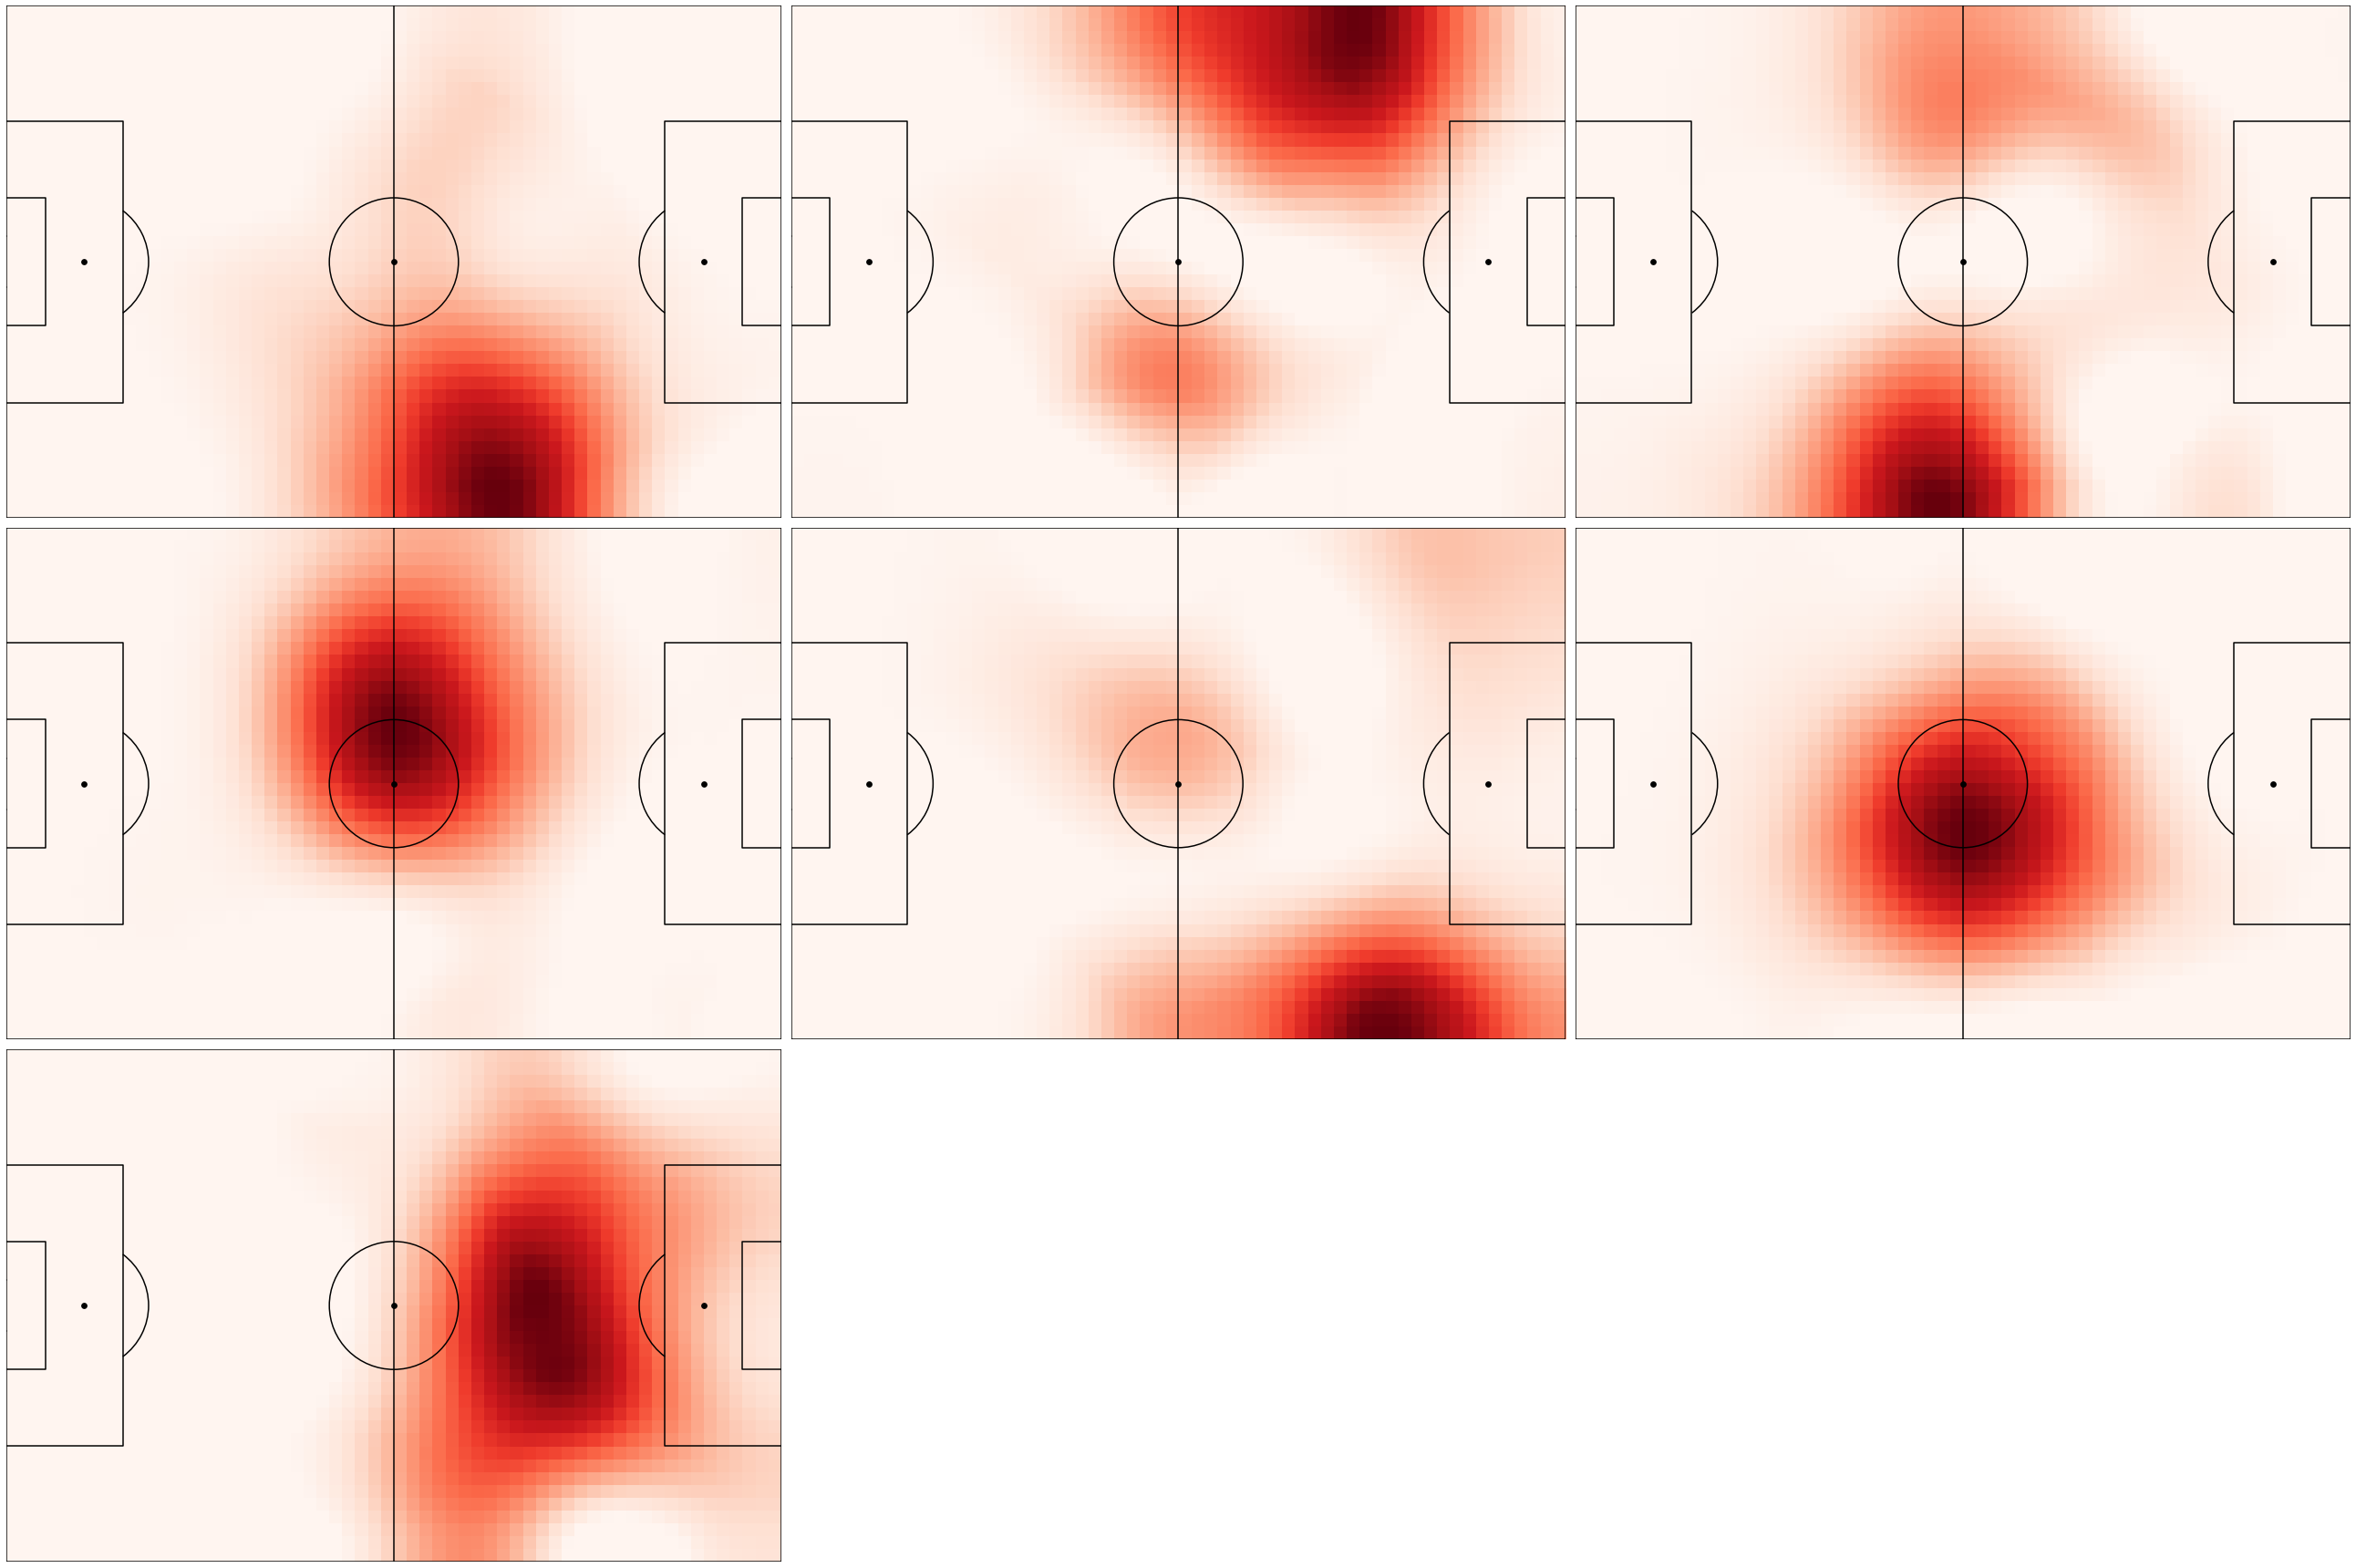

In [59]:
n_com = 7
model = skd.NMF(n_components=n_com, init='random', random_state=42)
W_cmid_car = model.fit_transform(X_cmid_car)
H_cmid_car = model.components_

n_rows = 3
n_cols = 3
n_components = n_com
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12*n_cols,8*n_rows))
count = 0
for i in range(n_rows):
    for j in range(n_cols):
        if count > n_components-1:
            axs[i, j].remove()
        else:
            _, ax = dp.draw_pitch('w','k','h','f',figax=(fig,axs[i,j]))
            ax.imshow(H_cmid_car[count].reshape(40,60), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
        count += 1
        
plt.tight_layout()

In [60]:
df_weights_cmid_car = pd.DataFrame(W_cmid_car, index=df_cmid_car.index, columns=['Zone {}'.format(i) for i in range(n_com)])

In [61]:
[df_weights_cmid_car['Zone {}'.format(i)].sort_values(ascending=False)[:5] for i in range(n_com)]

[Jill Scott        0.569914
 Lia Wälti         0.414201
 Chloe Arthur      0.233058
 Rachel Furness    0.204734
 Fara Williams     0.188386
 Name: Zone 0, dtype: float64,
 Georgia Stanway    0.499303
 Rachel Furness     0.305924
 Lucy Staniforth    0.268595
 So-yun Ji          0.266292
 Brianna Visalli    0.256471
 Name: Zone 1, dtype: float64,
 Laura Coombs                         0.166240
 Kate Longhurst                       0.153641
 Lucy Graham                          0.149481
 Dominique Johanna Anna Bloodworth    0.142826
 Lucy Staniforth                      0.138703
 Name: Zone 2, dtype: float64,
 Keira Walsh       0.281493
 Lia Wälti         0.235962
 Chloe Arthur      0.225721
 Hayley Ladd       0.123411
 Rachel Furness    0.113147
 Name: Zone 3, dtype: float64,
 Georgia Stanway    0.312888
 Lucy Staniforth    0.254454
 So-yun Ji          0.224489
 Kim Little         0.218055
 Kate Longhurst     0.141952
 Name: Zone 4, dtype: float64,
 Jill Scott                           0.

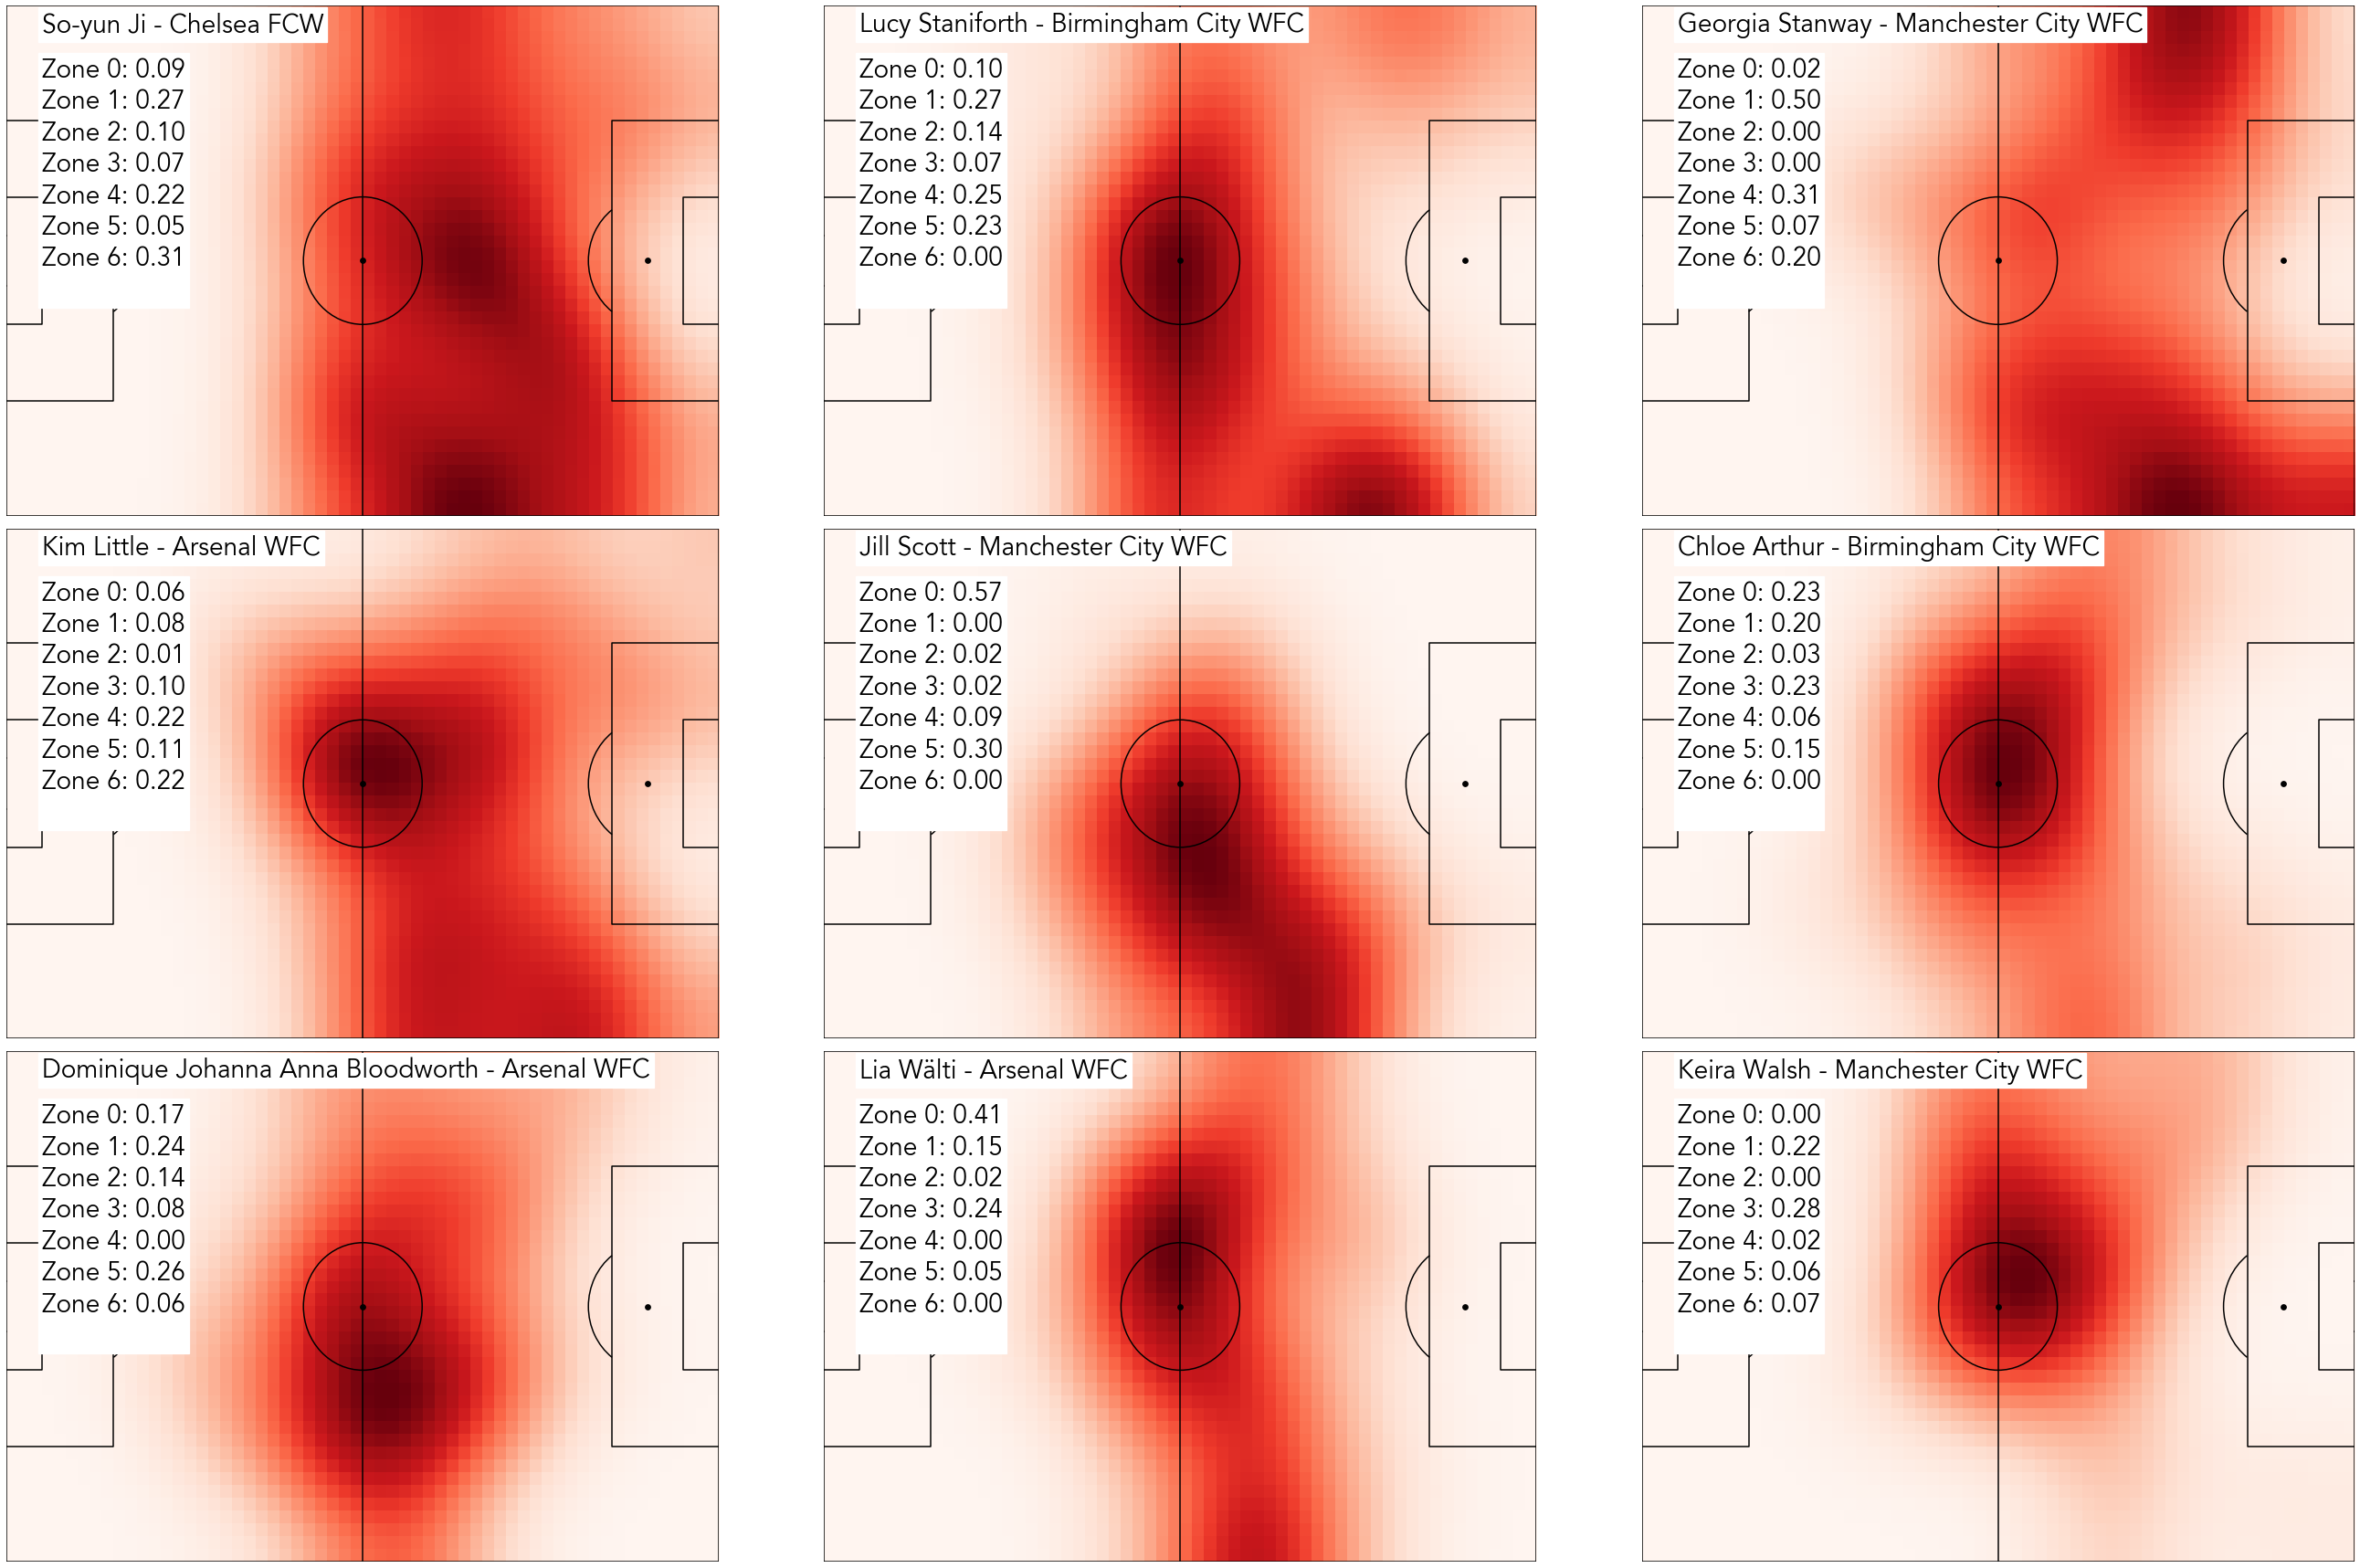

In [62]:
n_rows = 3
n_cols = 3
n_players = 9
fig, axs = plt.subplots(n_rows, n_cols, figsize=(36,8*n_rows))
count = 0
for i in range(n_rows):
    for j in range(n_cols):
        if count > n_players-1:
            axs[i, j].remove()
        else:
            _, ax = dp.draw_pitch('w','k','h','f',figax=(fig,axs[i,j]))
            ax.imshow(X_cmid_car[count].reshape(40,60), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
            ax.text(0.05,0.95,str(df_cmid_car.index[count])+" - "+str(df_cmid_car['team'][count]),
                    transform=ax.transAxes,fontsize=28,
                    ha='left',backgroundcolor='w')
            ax.text(0.05,0.9,player_zone_ratings(n_com,df_weights_cmid_car,count),
                    transform=ax.transAxes,ha='left',va='top',
                    fontsize=28,backgroundcolor='w')
        count += 1
        
plt.tight_layout()

## Future Ideas

To perform a more complete analysis of the central midfielders the ratings for shots, passes and carries could be combined into a single describing each player. Then a comparison between these complete vectors can be made to see which midfielders are similar across all areas.